# HR Analytics: Understanding Employee Attrition
Analyzing trends and patterns in employee attrition using HR analytics data from Kaggle. The data is on the company, Atlas Lab. [HR Analytics Employee Attrition and Performance] (https://www.kaggle.com/datasets/mahmoudemadabdallah/hr-analytics-employee-attrition-and-performance/data)

## Objectives
1. Exploratory Data Analysis (EDA)
    - Understand the characteristics of the workplace through visualization
    - Investigate the differences between employees who stayed versus those who left
    - Identify the most significant predictors that are associated with attrition
2. Predictive Modeling
    - Develop machine learning models to predict attrition using a combination of random forest and logistic regression
    - Evaluate each model's performance using metrics such as accuracy, precision, and recall scores
    - Provide actionable insights in choosing the best model to help improve employee retention

In [62]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy.stats import skew, kurtosis, normaltest, probplot
from univariate import ql_stats, dt_stats
from bivariate import nparametric_tests, interpret_results
from bivariate_viz import bivar_spearman_plot
import scipy.stats as stats
from pandas.api.types import CategoricalDtype
from attrition_modeling import run_pipeline

## Load and Clean Data
Load two datasets: **'employee.csv'** and **'performance.csv'**

In [3]:
df_employee = pd.read_csv('data/Employee.csv')
df_performance = pd.read_csv('data/PerformanceRating.csv')

In [4]:
df_employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   EmployeeID               1470 non-null   object
 1   FirstName                1470 non-null   object
 2   LastName                 1470 non-null   object
 3   Gender                   1470 non-null   object
 4   Age                      1470 non-null   int64 
 5   BusinessTravel           1470 non-null   object
 6   Department               1470 non-null   object
 7   DistanceFromHome (KM)    1470 non-null   int64 
 8   State                    1470 non-null   object
 9   Ethnicity                1470 non-null   object
 10  Education                1470 non-null   int64 
 11  EducationField           1470 non-null   object
 12  JobRole                  1470 non-null   object
 13  MaritalStatus            1470 non-null   object
 14  Salary                   1470 non-null  

In [5]:
df_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6709 entries, 0 to 6708
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   PerformanceID                    6709 non-null   object
 1   EmployeeID                       6709 non-null   object
 2   ReviewDate                       6709 non-null   object
 3   EnvironmentSatisfaction          6709 non-null   int64 
 4   JobSatisfaction                  6709 non-null   int64 
 5   RelationshipSatisfaction         6709 non-null   int64 
 6   TrainingOpportunitiesWithinYear  6709 non-null   int64 
 7   TrainingOpportunitiesTaken       6709 non-null   int64 
 8   WorkLifeBalance                  6709 non-null   int64 
 9   SelfRating                       6709 non-null   int64 
 10  ManagerRating                    6709 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 576.7+ KB


## df_employee & df_performance
- **df_employee** has 22 columns while **df_performance** has only 10
    - both have a common key, **"EmployeeID"**
    - amongst **df_employee**, it has numerical, categorical, datetime, and ordinal variables
    - **df_performance** only has ordinal, datetime, and one categorical variable
- while **df_employee** has 1470 entries, **df_performance** has 6709
    - **df_performance** has more entries due to some employees having multiple review dates

In [6]:
# change ReviewDate to datetime
df_performance["ReviewDate"] = pd.to_datetime(df_performance["ReviewDate"])
# sort performance by employee + review date
df_performance = df_performance.sort_values(["EmployeeID", "ReviewDate"])
# keep the most recent review for each employee
df_performance = df_performance.groupby("EmployeeID").tail(1)

Before merging, we should turn **ReviewDate** into a datetime variable. We also need to sort **df_performance** in chronological order. This way, when we remove duplicate employee entries, we only select the most recent review date for our cleaned dataset.

In [7]:
df_hr_only = df_employee.copy()

df_with_reviews = pd.merge(df_employee, df_performance, on='EmployeeID', how='inner')

df_all = pd.merge(df_employee, df_performance, on='EmployeeID', how='left')

**df_hr_only** only contains data from df_employee, which contains **1470** employees.

**df_with_reviews** contains data from both **df_employee** and **df_performance**, which contains only **1280** employees that have reviews.

**df_all** contains data from all **1470** employees + their performance, regardless if an employee has been reviewed yet. There are **190** missing data values, which are the number of employees who have not been reviwed yet.

In [8]:
# map binary columns
cleaned_df = [df_hr_only, df_with_reviews, df_all]
for df in cleaned_df:
    df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
    df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

In [9]:
# mapping ordinal columns
satisfaction_map = {
    1: 'Very Dissatisfied',
    2: 'Dissatisfied',
    3: 'Neutral',
    4: 'Satisfied',
    5: 'Very Satisfied'
}

performance_map = {
    1: 'Unacceptable',
    2: 'Needs Improvement',
    3: 'Meets Expectations',
    4: 'Exceeds Expectation',
    5: 'Above and Beyond'
}

education_map = {
    1: 'No Formal Qualifications',
    2: 'High School',
    3: 'Bachelors',
    4: 'Masters',
    5: 'Doctorate'
}

# ensure Education is present for mapping
for df in cleaned_df:
    if 'Education' not in df.columns:
        # if somehow lost during merge, bring it from df_employee
        df = df.merge(df_employee[['EmployeeID', 'Education']], on='EmployeeID', how='left')

# define ordinal mappings by column
ordinal_mappings = {
    'EnvironmentSatisfaction': satisfaction_map,
    'JobSatisfaction': satisfaction_map,
    'RelationshipSatisfaction': satisfaction_map,
    'WorkLifeBalance': satisfaction_map,
    'SelfRating': performance_map,
    'ManagerRating': performance_map,
    'Education': education_map
}

# apply mappings
for col, mapping in ordinal_mappings.items():
    for df in cleaned_df:
        if col in df.columns:
            df[col] = df[col].map(mapping)
            df[col] = pd.Categorical(df[col], categories=list(mapping.values()), ordered=True)

Map binary columns: **OverTime** and **Attrition**
Map ordinal columns in cleaned_df: **EnvironmentSatisfaction**, **JobSatisfaction**, **RelationshipSatsifaction**, **WorkLifeBalance**, **SelfRating**, **ManagerRating** and **Education**.
- Levels gathered from "RatingLevel.csv", "EducationLevel.csv", and "SatisfiedLevel.csv"
- **StockOptionLevel** has no specific level mapping.
- **Education** and **StockOptionLevel** are the only ordinal variables in "Employee.csv"

In [10]:
# convert the rest of the categorical columns
categorical_cols = [ 
    'Gender', 'BusinessTravel', 'Department', 'State',
        'Ethnicity', 'EducationField', 
    'JobRole', 'MaritalStatus', 'StockOptionLevel']
for col in categorical_cols:
    for df in cleaned_df:
        df[col] = df[col].astype('category')

# make sure any date columns are in datetime
for df in cleaned_df:
    df['HireDate'] = pd.to_datetime(df['HireDate'])

# fix typos in EducationField
for df in cleaned_df:
    if 'EducationField' in df.columns:
        df['EducationField'] = df['EducationField'].str.strip().str.title()
        df['EducationField'] = df['EducationField'].replace({
            'Marketing ': 'Marketing',
            'Marketting': 'Marketing'
        })
# make sure EducationField is categorical
df['EducationField'] = df['EducationField'].astype('category')

The rest of the categorical variables are **Gender**, **BusinessTravel**, **Department**, **State**, **Ethnicity**, **EducationField**, **JobRole**, **MaritalStatus**, and **StockOptionLevel**.

In [11]:
# drop unused columns
df_hr_only = df_hr_only.drop(columns=['FirstName', "LastName", "EmployeeID"])

df_with_reviews = df_with_reviews.drop(columns=['FirstName', 'LastName', 'PerformanceID', "EmployeeID"])
df_all = df_all.drop(columns=['FirstName', 'LastName', 'PerformanceID', 'EmployeeID'])

In [12]:
df_hr_only.head()

,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),State,Ethnicity,Education,EducationField,JobRole,MaritalStatus,Salary,StockOptionLevel,OverTime,HireDate,Attrition,YearsAtCompany,YearsInMostRecentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Female,30,Some Travel,Sales,27,IL,White,Doctorate,Marketing,Sales Executive,Divorced,102059,1,0,2012-01-03,0,10,4,9,7
1,Male,38,Some Travel,Sales,23,CA,White,Masters,Marketing,Sales Executive,Single,157718,0,1,2012-01-04,0,10,6,10,0
2,Male,43,Some Travel,Human Resources,29,CA,Asian or Asian American,Masters,Marketing,HR Business Partner,Married,309964,1,0,2012-01-04,0,10,6,10,8
3,Non-Binary,39,Some Travel,Technology,12,IL,White,Bachelors,Computer Science,Engineering Manager,Married,293132,0,0,2012-01-05,0,10,10,10,0
4,Female,29,Some Travel,Human Resources,29,CA,White,High School,Technical Degree,Recruiter,Single,49606,0,0,2012-01-05,1,6,1,1,6


In [13]:
df_with_reviews.head()

,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),State,Ethnicity,Education,EducationField,JobRole,...,YearsWithCurrManager,ReviewDate,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction,TrainingOpportunitiesWithinYear,TrainingOpportunitiesTaken,WorkLifeBalance,SelfRating,ManagerRating
0,Female,30,Some Travel,Sales,27,IL,White,Doctorate,Marketing,Sales Executive,...,7,2022-10-29,Satisfied,Dissatisfied,Satisfied,1,0,Dissatisfied,Above and Beyond,Exceeds Expectation
1,Male,38,Some Travel,Sales,23,CA,White,Masters,Marketing,Sales Executive,...,0,2022-07-29,Neutral,Satisfied,Satisfied,3,0,Dissatisfied,Above and Beyond,Exceeds Expectation
2,Male,43,Some Travel,Human Resources,29,CA,Asian or Asian American,Masters,Marketing,HR Business Partner,...,8,2022-04-07,Satisfied,Very Satisfied,Neutral,3,0,Satisfied,Exceeds Expectation,Meets Expectations
3,Non-Binary,39,Some Travel,Technology,12,IL,White,Bachelors,Computer Science,Engineering Manager,...,0,2022-03-26,Very Dissatisfied,Satisfied,Neutral,2,2,Neutral,Meets Expectations,Meets Expectations
4,Female,29,Some Travel,Human Resources,29,CA,White,High School,Technical Degree,Recruiter,...,6,2021-05-12,Neutral,Satisfied,Neutral,1,2,Very Satisfied,Meets Expectations,Needs Improvement


In [14]:
df_all.head()

,Gender,Age,BusinessTravel,Department,DistanceFromHome (KM),State,Ethnicity,Education,EducationField,JobRole,...,YearsWithCurrManager,ReviewDate,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction,TrainingOpportunitiesWithinYear,TrainingOpportunitiesTaken,WorkLifeBalance,SelfRating,ManagerRating
0,Female,30,Some Travel,Sales,27,IL,White,Doctorate,Marketing,Sales Executive,...,7,2022-10-29,Satisfied,Dissatisfied,Satisfied,1.0,0.0,Dissatisfied,Above and Beyond,Exceeds Expectation
1,Male,38,Some Travel,Sales,23,CA,White,Masters,Marketing,Sales Executive,...,0,2022-07-29,Neutral,Satisfied,Satisfied,3.0,0.0,Dissatisfied,Above and Beyond,Exceeds Expectation
2,Male,43,Some Travel,Human Resources,29,CA,Asian or Asian American,Masters,Marketing,HR Business Partner,...,8,2022-04-07,Satisfied,Very Satisfied,Neutral,3.0,0.0,Satisfied,Exceeds Expectation,Meets Expectations
3,Non-Binary,39,Some Travel,Technology,12,IL,White,Bachelors,Computer Science,Engineering Manager,...,0,2022-03-26,Very Dissatisfied,Satisfied,Neutral,2.0,2.0,Neutral,Meets Expectations,Meets Expectations
4,Female,29,Some Travel,Human Resources,29,CA,White,High School,Technical Degree,Recruiter,...,6,2021-05-12,Neutral,Satisfied,Neutral,1.0,2.0,Very Satisfied,Meets Expectations,Needs Improvement


In [15]:
print(df_hr_only.isnull().sum())
print(df_with_reviews.isnull().sum())
print(df_all.isnull().sum())

Gender                     0
Age                        0
BusinessTravel             0
Department                 0
DistanceFromHome (KM)      0
State                      0
Ethnicity                  0
Education                  0
EducationField             0
JobRole                    0
MaritalStatus              0
Salary                     0
StockOptionLevel           0
OverTime                   0
HireDate                   0
Attrition                  0
YearsAtCompany             0
YearsInMostRecentRole      0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64
Gender                             0
Age                                0
BusinessTravel                     0
Department                         0
DistanceFromHome (KM)              0
State                              0
Ethnicity                          0
Education                          0
EducationField                     0
JobRole                            0
MaritalStatus                      0


## 1. Exploratory Data Analysis - Univariate Variables
Observe any visible patterns or trends we may want to look further into.
<br>Also check for distribution & normality.

- For categorical columns, a count plot is created alongside the summary
- For numerical columns, a boxplot, histogram, and qq-plot are created alongside the summary, skew/kurtosis, and normality test.
- For datetime columns, a count plot by years is created with the summary

*all plots can be viewed in the folder "plots"*

In [16]:
sns.set(style='whitegrid', palette='tab20c')
plt.rcParams['figure.figsize'] = (10, 6)


--- Categorical Summary: Attrition ---
           Count  Percentages
Attrition                    
0           1233        83.88
1            237        16.12
Unique categories: 2
Most frequent: 0


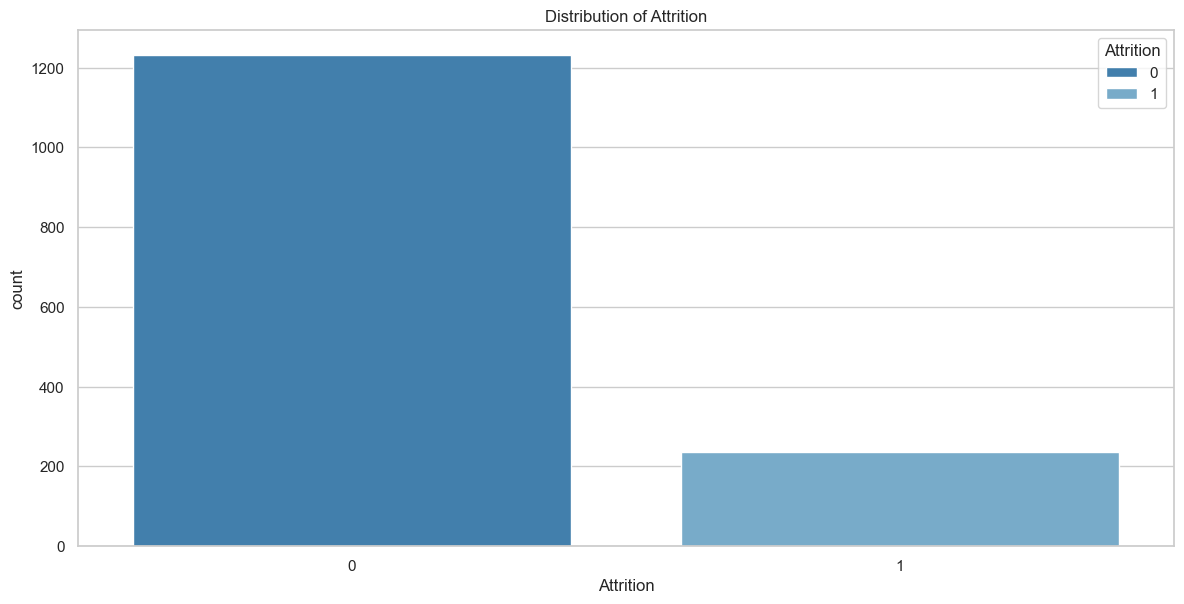

In [17]:
# using df_hr_only (without performance data)
df = df_hr_only
# attrition count plot
ql_stats(df, 'Attrition')

- There's **83.88%** of non-attrition in employees or **16.12%** of attrition. 
- The company seems to have a healthy or positive retention rate, **75%** of the company has stayed with the company so far.


--- Categorical Summary: Gender ---
                   Count  Percentages
Gender                               
Female               675        45.92
Male                 651        44.29
Non-Binary           124         8.44
Prefer Not To Say     20         1.36
Unique categories: 4
Most frequent: Female


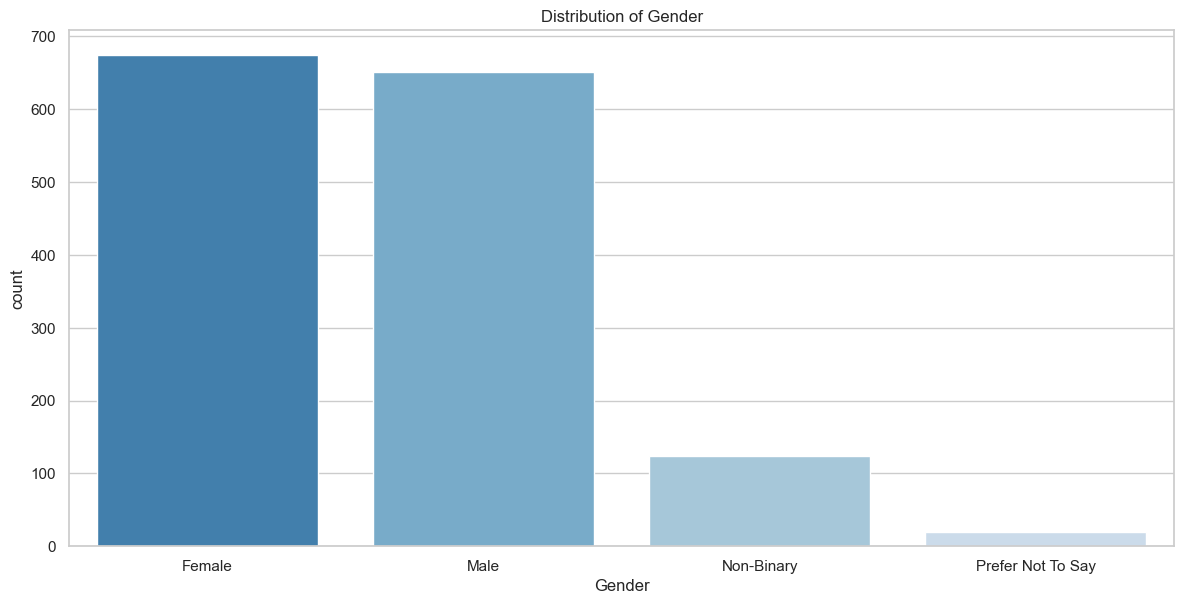

In [18]:
ql_stats(df, 'Gender')

- **90.21%** of the company identify as either **Female** or **Male**
- The most frequent gender is **Female** at **45.92%**. 
- Only **20** employees out of 1470 selected **"Prefer Not To Say"**, making it the least frequent category. 

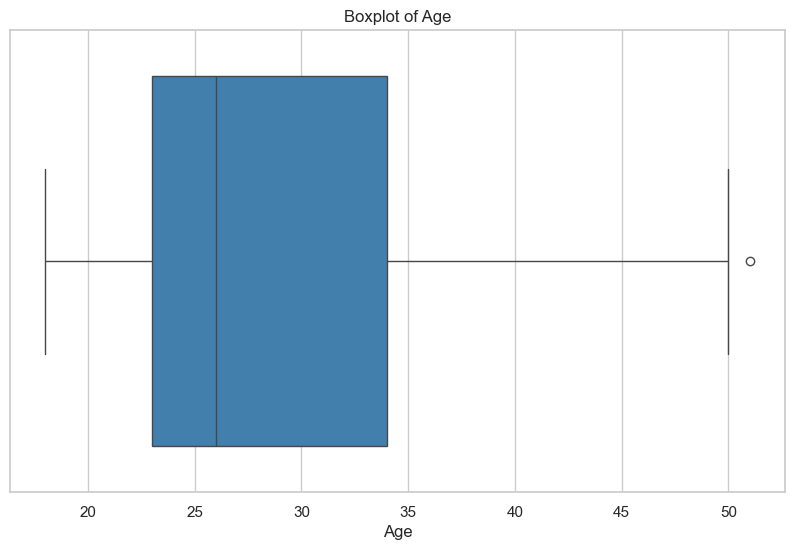

--- Numerical Summary: Age ---
count    1470.000000
mean       28.989796
std         7.993055
min        18.000000
25%        23.000000
50%        26.000000
75%        34.000000
max        51.000000
Name: Age, dtype: float64

Mode: 25
Skewness: 0.89
Kurtosis: 0.36


In [19]:
# boxplot
sns.boxplot(x=df['Age'])
plt.title("Boxplot of Age")
plt.xlabel('Age')
plt.show()

# summary
print("--- Numerical Summary: Age ---")
desc = df['Age'].describe()
print(desc)

# mode
print(f"\nMode: {df['Age'].mode()[0]}")
#skewness + kurtosis
print(f"Skewness: {skew(df['Age'].dropna()):.2f}")
print(f"Kurtosis: {kurtosis(df[col].dropna()):.2f}")


- Average **age** of employees is **28 years**
- Most of the employees are between **23 and 34 years old**. 
- The youngest employee is age **18**, while the oldest is **51**. 
- **Right-skewed** distribution, with a larger concentration of younger employees
- The workforce is fairly young, with fewer employees being older than **35**.

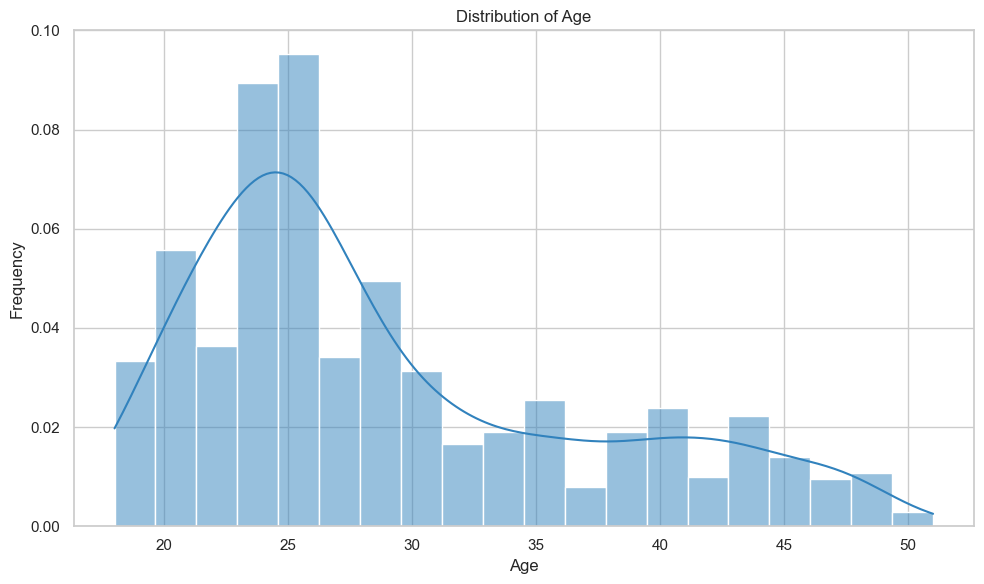


D'Agostino and Pearson Test:
Statistic = 151.4004, p-value = 0.0000
Data is not normally distributed.


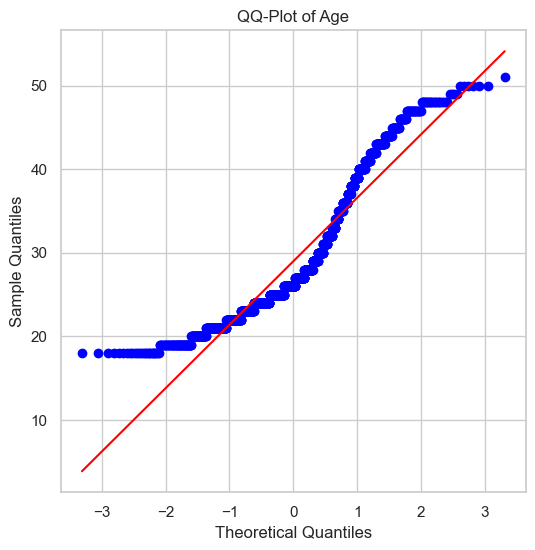

In [20]:
# histogram + kde
sns.histplot(df['Age'], kde=True, stat='density', bins=20)
plt.title("Distribution of Age")
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# normality test
stat, p=normaltest(df['Age'])
print(f"\nD'Agostino and Pearson Test:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")
if p < 0.05: # 95% confidence
    print("Data is not normally distributed.")
else:
    print("Data is normally distributed.")

# QQ plot
plt.figure(figsize=(6,6))
probplot(df['Age'], dist='norm', plot=plt)
plt.title("QQ-Plot of Age")
plt.xlabel("Theoretical Quantiles")
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

- The histogram with KDE and the QQ plot confirm that the age distribution **deviates from normality**, showing a **right-skew**. 
- Most employees are concentrated around their **mid-20s**, with a peak just above age **25**. 
- Beyond age **30**, the number of employees gradually decreases and the distribution flattens, suggesting a relatively smaller but consistent precense of older employees. 
- This pattern could be due to higher attrition among older employees, or it may reflect the company's preference for hiring younger talent.


--- Categorical Summary: BusinessTravel ---
                    Count  Percentages
BusinessTravel                        
Some Travel          1043        70.95
Frequent Traveller    277        18.84
No Travel             150        10.20
Unique categories: 3
Most frequent: Some Travel


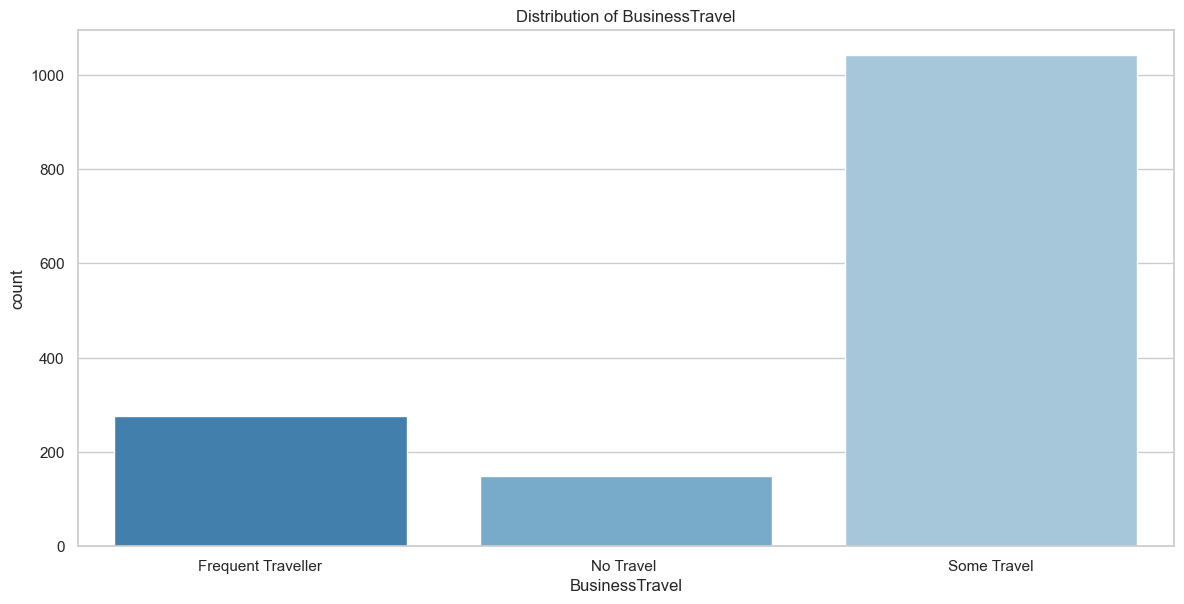

In [21]:
ql_stats(df, 'BusinessTravel')

- The most common is **"Some Travel"**, at a percentage of **70.95%**. 
- Low counts of employees for **"Frequent Traveler"** and **"No Travel"**
- Can be inferred that while frequent traveling may not be required by the company, employees are still required to travel occasionally.
- Difference can be due to job role, or distance from work.


--- Categorical Summary: Department ---
                 Count  Percentages
Department                         
Technology         961        65.37
Sales              446        30.34
Human Resources     63         4.29
Unique categories: 3
Most frequent: Technology


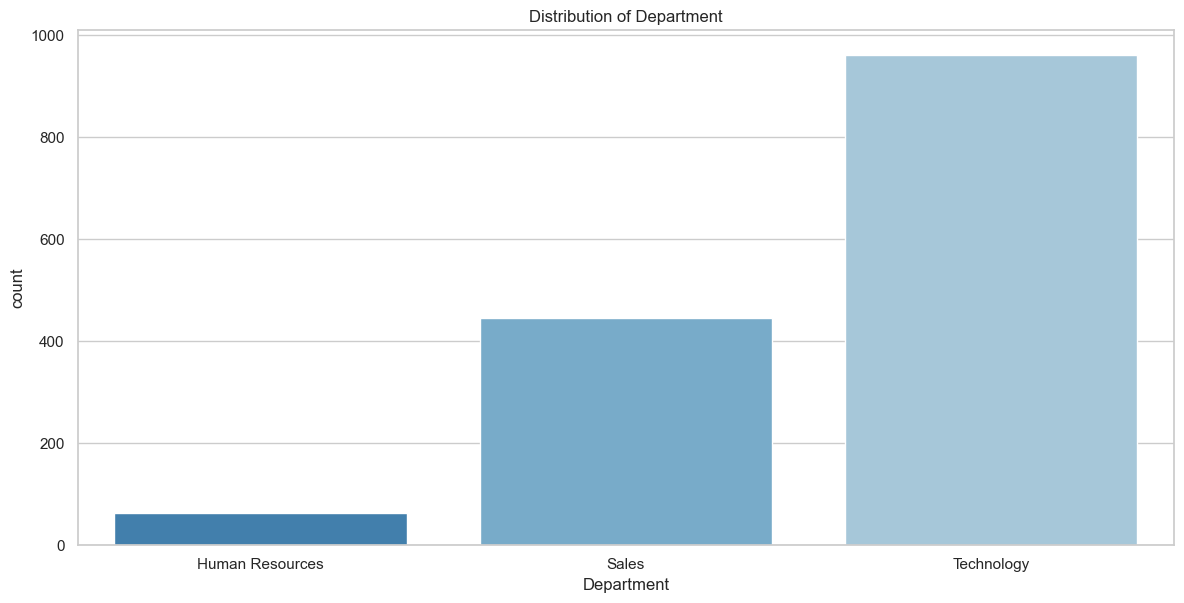

In [22]:
ql_stats(df, 'Department')

- Two most biggest departments are **Sales and Technology**
- **More than half** of employees work in **Technology**. 
- **446** employees work in **Sales**, at **30.34%** 
- Only **63** out of **1470** employees work in **Human Resources**. 
- Can be inferred that the company mainly focuses on the **Technology** and **Sales** departments. 

*For more plots related to Department, look at Education Field and Job Role.*


--- Categorical Summary: State ---
       Count  Percentages
State                    
CA       875        59.52
NY       419        28.50
IL       176        11.97
Unique categories: 3
Most frequent: CA


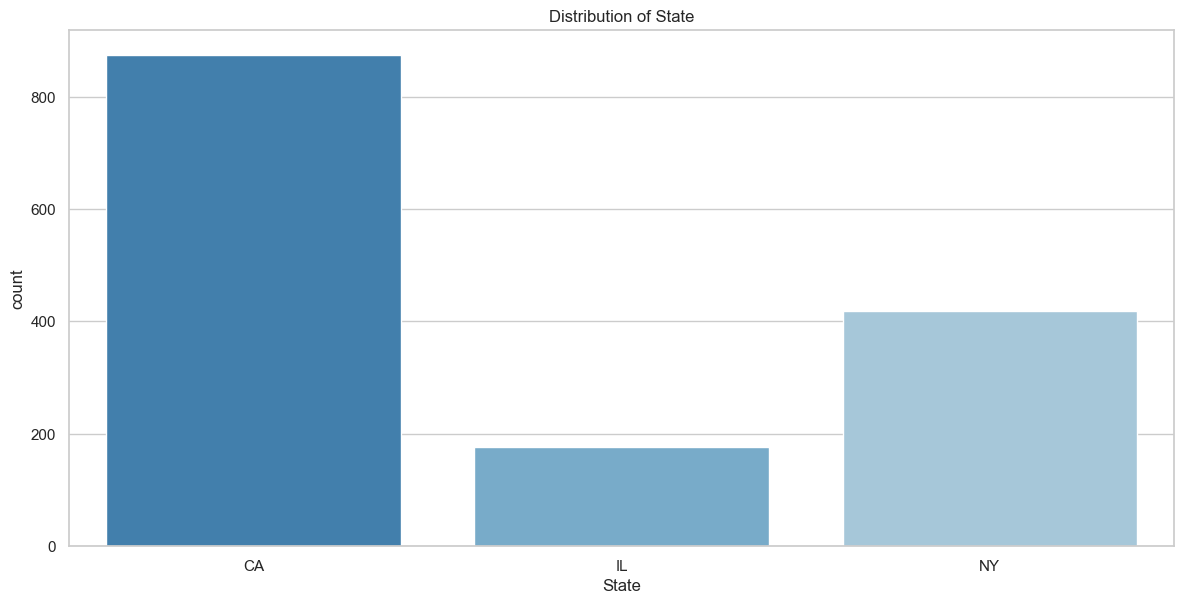

In [24]:
ql_stats(df, 'State')

- **59.52%** of employees reside in **California**, while **28.50%** in **New York**, and **11.97%** in **Illnois**. 
- Could be due to smaller offices around **NY and IL**, or that most of the company could be **CA** based, with their larger offices located there. 
- Only **3** states that were reported in this dataset, suggesting that this company requires employees to work onsite or hybrid.

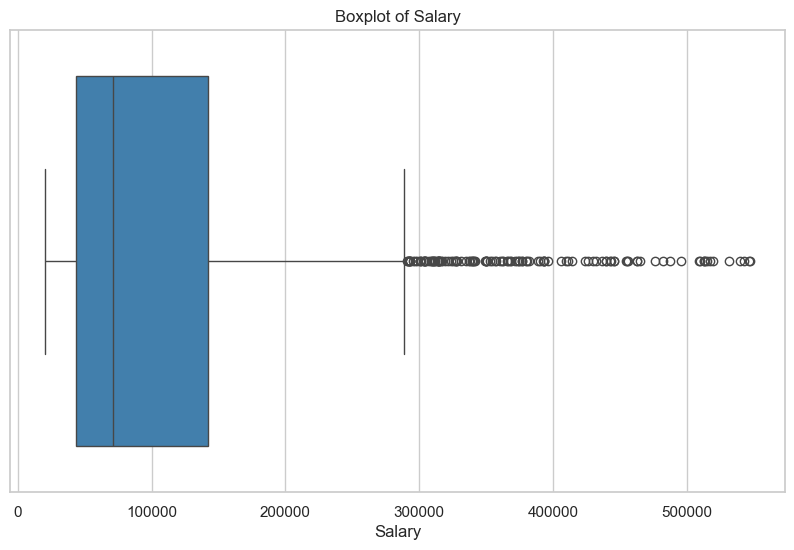

--- Numerical Summary: Salary ---
count      1470.000000
mean     112956.497959
std      103342.889222
min       20387.000000
25%       43580.500000
50%       71199.500000
75%      142055.750000
max      547204.000000
Name: Salary, dtype: float64

Mode: 26973
Skewness: 1.78
Kurtosis: 2.92


In [25]:
# boxplot
sns.boxplot(x=df['Salary'])
plt.title("Boxplot of Salary")
plt.xlabel('Salary')
plt.show()

# summary
print("--- Numerical Summary: Salary ---")
desc = df['Salary'].describe()
print(desc)

# mode
print(f"\nMode: {df['Salary'].mode()[0]}") 
# skewness + kurtosis
print(f"Skewness: {skew(df['Salary'].dropna()):.2f}")
print(f"Kurtosis: {kurtosis(df['Salary'].dropna()):.2f}")

- Boxplot is **right-skewed**, most of the data is clustered over to the left, meaning that most employees are paid a lower salary between **$43,580 - $142,056**
- Has a **higher kurtosis**, shown by heavier tails with more extreme outliers
- Indicates that it's rare for an employee to have high salary at this company. 

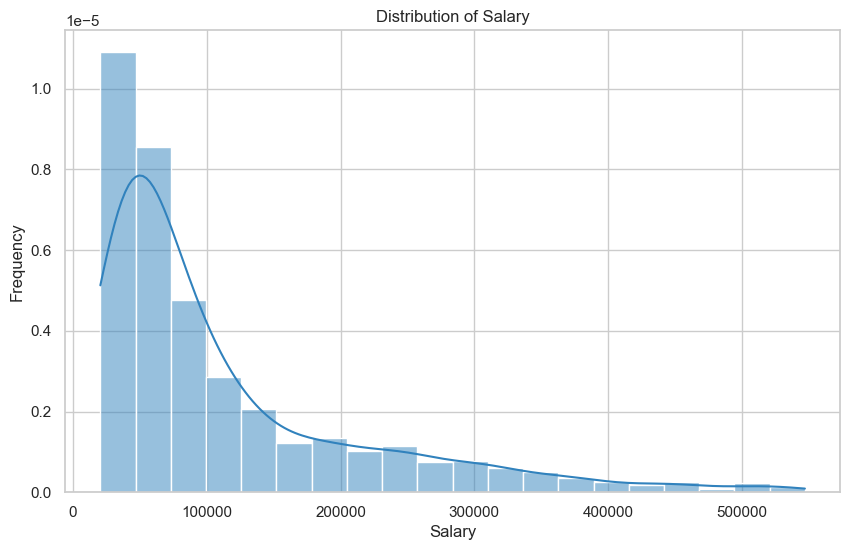

In [26]:
# histogram + kde
sns.histplot(df['Salary'], kde=True, stat='density', bins=20)
plt.title("Distribution of Salary")
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()


- Shows a **higher density** of employees that earn a **lower wage**
- A long **right-tail** that **decreases as the salary rises**. 
- The company may pay most of their employees at a lower salary wage, with less common cases of employees at a higher wage.


--- Categorical Summary: StockOptionLevel ---
                  Count  Percentages
StockOptionLevel                    
0                   631        42.93
1                   596        40.54
2                   158        10.75
3                    85         5.78
Unique categories: 4
Most frequent: 0


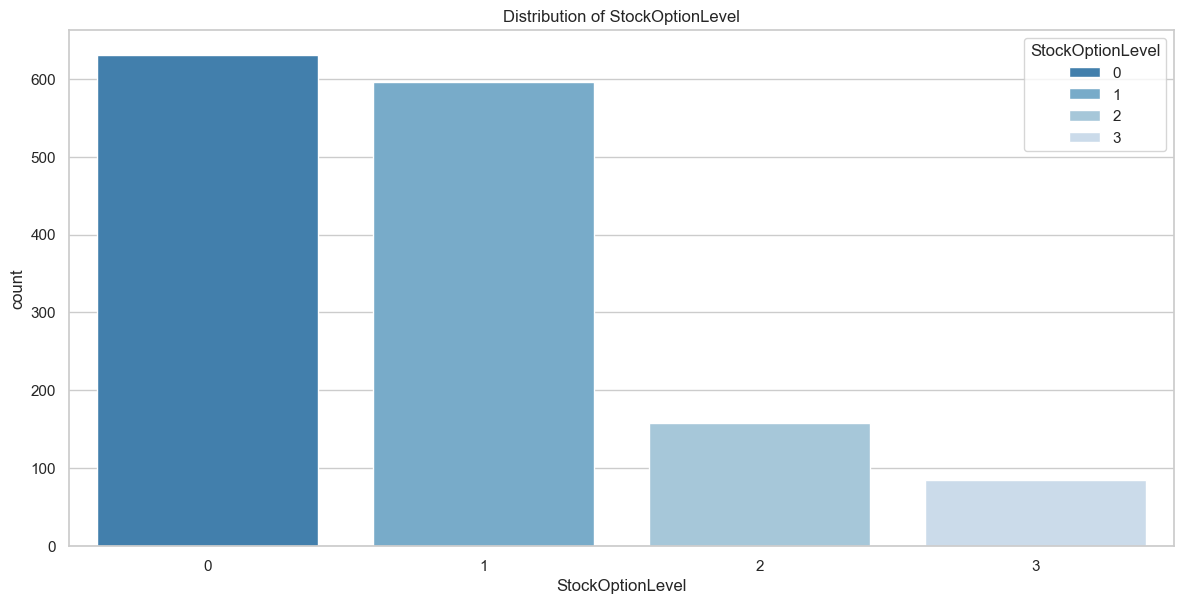

In [27]:
ql_stats(df, 'StockOptionLevel')

- **Stock Option Level** given to employees the most are **Stock Level 0 (42.93%) and Level 1 (40.54%)**
- **Stock Option Levels (2 and 3)** are given out to **fewer** employees
- Possibly that more generous stock options are reserved to a smaller portion of employees, likely those in higher positions or with longer tenure.


--- Categorical Summary: OverTime ---
          Count  Percentages
OverTime                    
0          1054         71.7
1           416         28.3
Unique categories: 2
Most frequent: 0


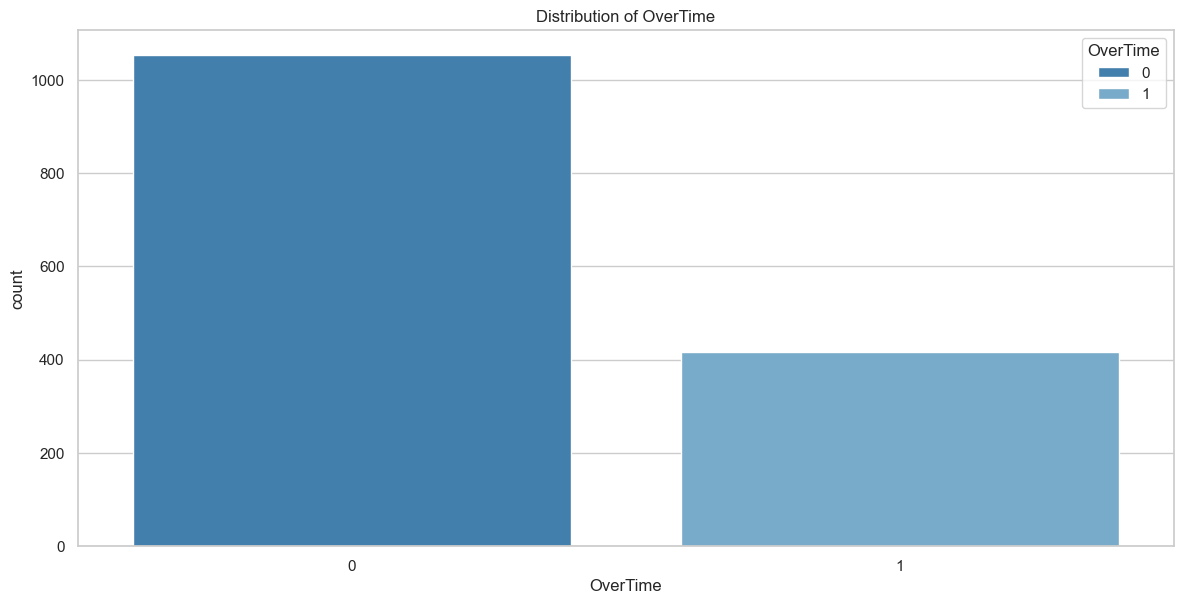

In [28]:
ql_stats(df, 'OverTime')

- **71.7%** of employees do not work **Overtime**, **28.3%** do work **Overtime**
- Implies that the vast of employees are not required or influenced to work past normal hours. 
- For the employees who do work overtime, it possibly could be due to other outside influences or job role.


--- Datetime Summary: HireDate ---
Min date: 2012-01-03 00:00:00
Max date: 2022-12-31 00:00:00
Range: 4015 days 00:00:00
Median: 2017-09-02 00:00:00
Mode: 2012-01-19 00:00:00
Unique dates: 1192

Counts per year:
HireDate
2012    151
2013    136
2014    136
2015    127
2016    114
2017    106
2018    136
2019    145
2020    127
2021    137
2022    155
Name: count, dtype: int64


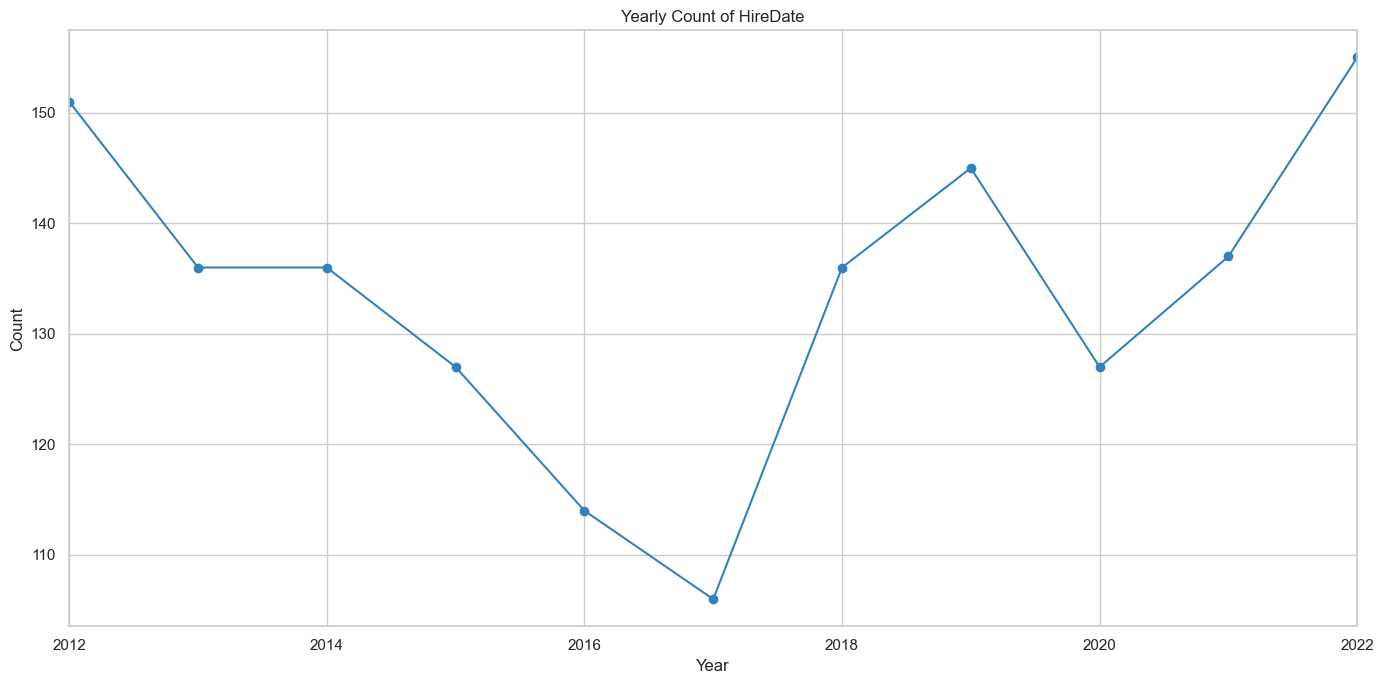

In [29]:
dt_stats(df, 'HireDate')

- **First** employee was hired on **January 3rd, 2012**
- **Most recent** hire was on **December 31st, 2022**
- The company is nearly a **decade old**.
- In **2012**, hiring gradually **decreased**, suggesting fewer open positions or a smaller workforce
- Around **2017-2018**, there is a sharp **increase** in hires, with **136** new employees in **2018**, likely due to expansion or higher turnover
- In **2020**, hiring **slowed**, likely impacted by the COVID-19 pandemic. 
- After **2020**, the number of new hires **steadily increased**, up to **155** in **2022**

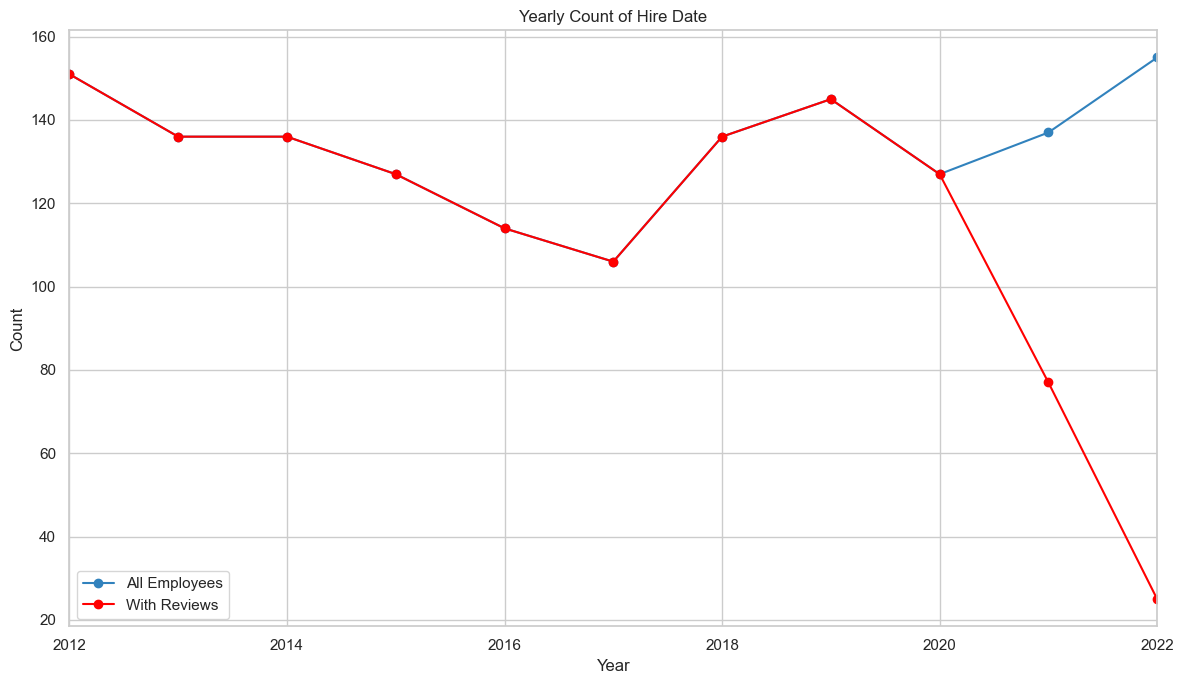

In [64]:
dt_yearly1 = df.set_index('HireDate').resample('YE').size()
dt_yearly2 = df_with_reviews.set_index('HireDate').resample('YE').size()

plt.figure(figsize=(12, 7))

# plot all employees
dt_yearly1.plot(marker='o', label='All Employees')

# plot employees with reviews
dt_yearly2.plot(marker='o', label='With Reviews', color='red')

plt.title("Yearly Count of Hire Date")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


- Compared to the dataset containing only employees with reviews, the hires **after 2020 appear to decrease** sharply. 
- This graph is one of the few where the review-only dataset noticably **diverges** from the full dataset.


--- Datetime Summary: ReviewDate ---
Min date: 2013-04-23 00:00:00
Max date: 2022-12-31 00:00:00
Range: 3539 days 00:00:00
Median: 2022-05-18 12:00:00
Mode: 2022-05-22 00:00:00
Unique dates: 494

Counts per year:
ReviewDate
2013       2
2014       7
2015       9
2016       7
2017      14
2018      17
2019      18
2020      27
2021      54
2022    1125
Name: count, dtype: int64


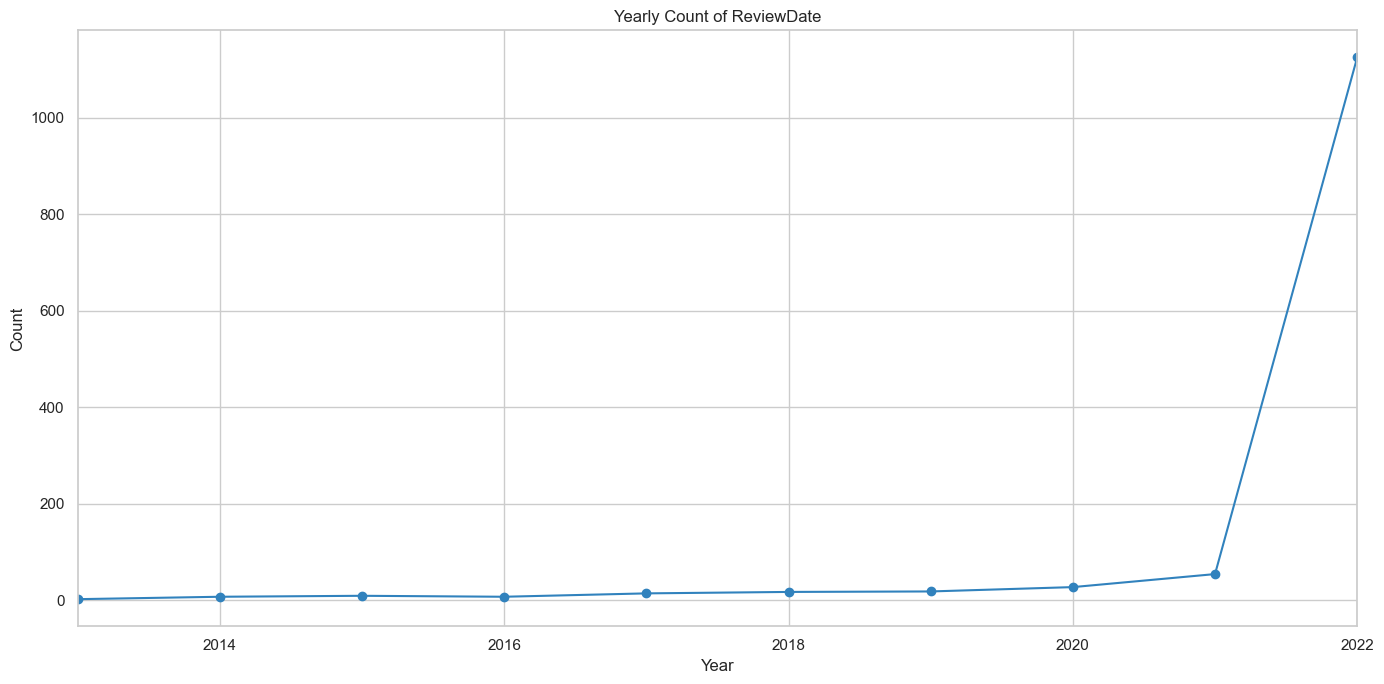

In [31]:
df2 = df_with_reviews
dt_stats(df2, 'ReviewDate')

- There is a dramatic **increase** in **review counts** in **2022**, from only **54** reviews in **2021** to over **1,100**. 
- Suggests that reviews may not be conducted for every employee annually.
- The low number of reviews in prior years indicates that reviews may only occur at specific milestones, for example, after a set tenure or prior to an employee leaving.

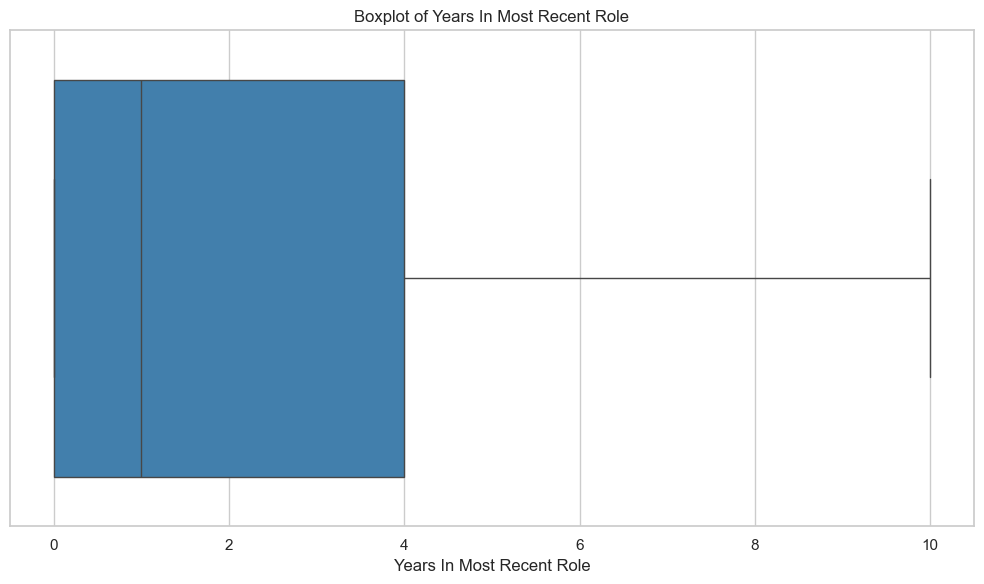


--- Numerical Summary: Years In Most Recent ---
count    1470.000000
mean        2.293197
std         2.539093
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        10.000000
Name: YearsInMostRecentRole, dtype: float64

Mode: 0
Skewness: 1.09
Kurtosis: 0.31


In [32]:
sns.boxplot(x=df['YearsInMostRecentRole'])
plt.title("Boxplot of Years In Most Recent Role")
plt.xlabel('Years In Most Recent Role')
plt.tight_layout()
plt.show()

# summary
print("\n--- Numerical Summary: Years In Most Recent ---")
desc = df['YearsInMostRecentRole'].describe()
print(desc)

# mode
print(f"\nMode: {df['YearsInMostRecentRole'].mode()[0]}") 
# skewness + kurtosis
print(f"Skewness: {skew(df['YearsInMostRecentRole'].dropna()):.2f}")
print(f"Kurtosis: {kurtosis(df['YearsInMostRecentRole'].dropna()):.2f}")

- Heavily **right-skewed**, with a **long tail end**
- Indicates that the amount of years an employee has stayed in their most recent role is on the **low end**, where **75%** of the company have stayed in their current role for **under 4 years**. 
- **Half of the company (50%)** have only stayed in their recent role for **under a year**
- Suggests that there might've been a huge structural change in the past few years. 

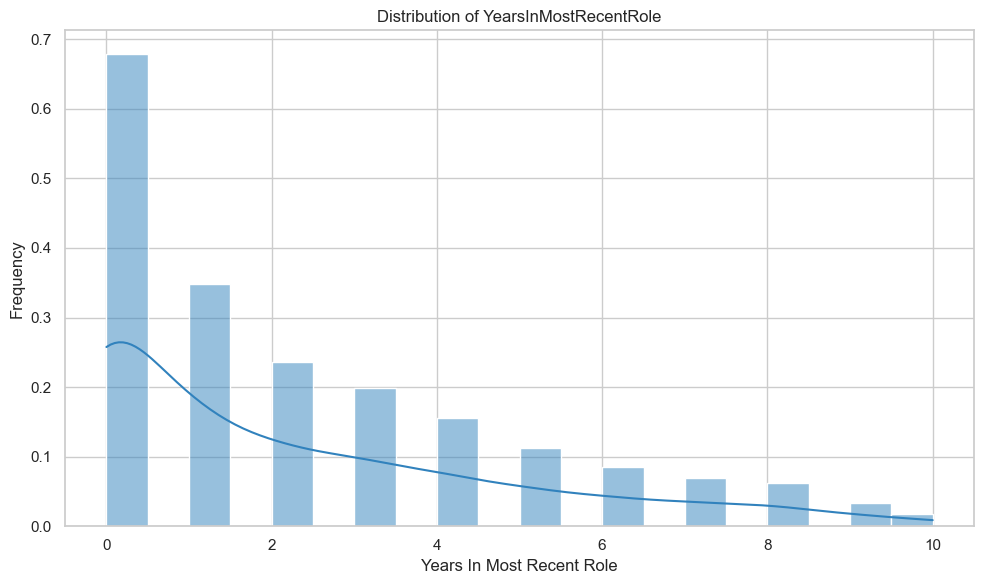

In [33]:
sns.histplot(df['YearsInMostRecentRole'], kde=True, stat='density', bins=20)
plt.title("Distribution of YearsInMostRecentRole")
plt.xlabel('Years In Most Recent Role')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

- Histogram confirms that the number of employees who have stayed in their current role **steadily decreases as the amount of years increase**. 
- Could indicate that either the employees who would've stayed there the longest, have already left
- Knowing that there was a big amount of hires in 2022, it could just represent a younger workforce

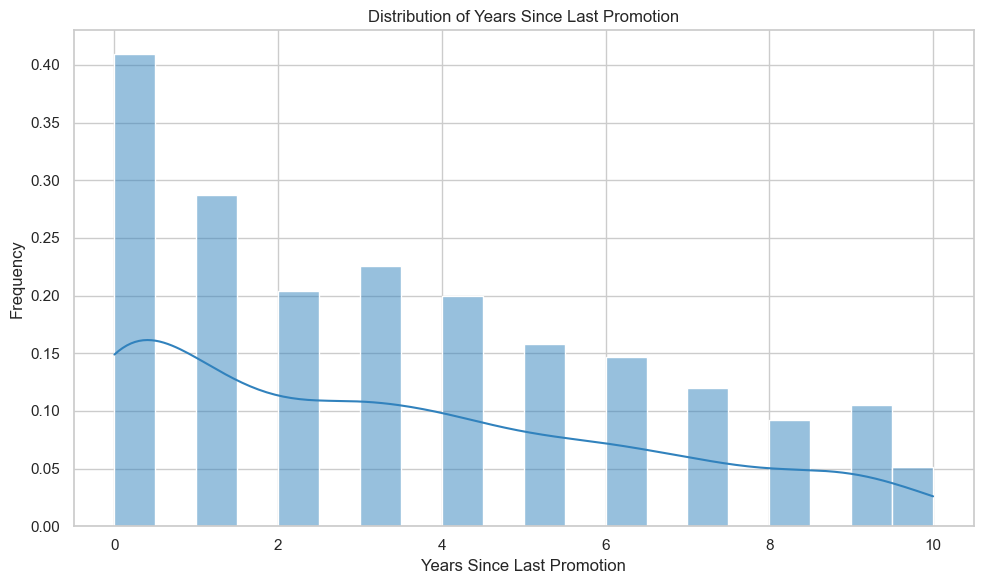

In [34]:
sns.histplot(df['YearsSinceLastPromotion'], kde=True, stat='density', bins=20)
plt.title("Distribution of Years Since Last Promotion")
plt.xlabel('Years Since Last Promotion')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

- We can see a similar pattern where **most employees** have only gone through **0-2 years** out from their last promotion. 
- Strongly implies that the YearsInMostRecentRole could be influenced by recent promotions, rather than due to quick turnover.

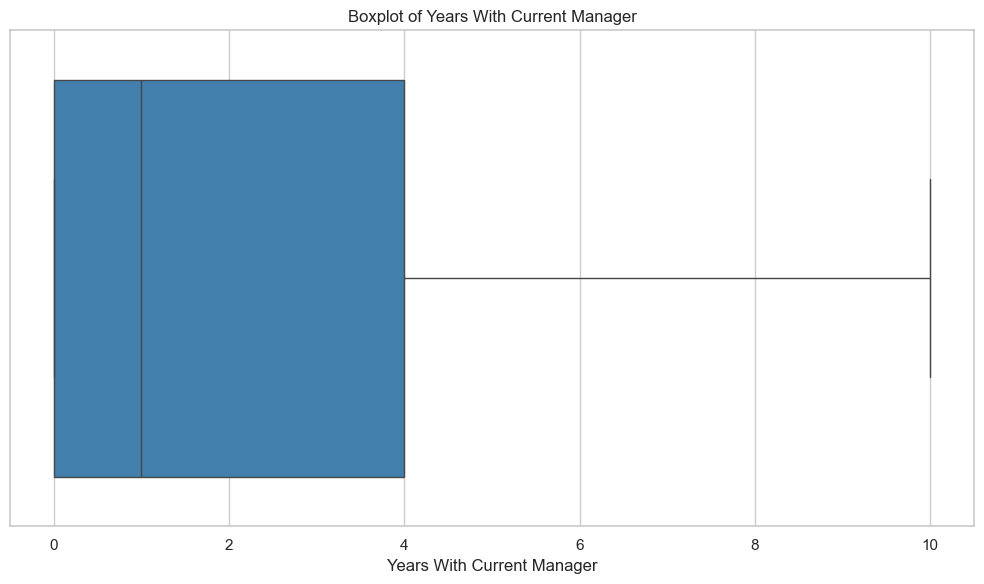

In [35]:
sns.boxplot(x=df['YearsWithCurrManager'])
plt.title("Boxplot of Years With Current Manager")
plt.xlabel('Years With Current Manager')
plt.tight_layout()
plt.show()

- Boxplot for **YearsWithCurrManager** shows the same trend: **right-skewed** with most of the data crowding between **years 0-4**. 
- Further points out that promotions, recent role and managerial changes are correlated with each other.


--- Categorical Summary: JobSatisfaction ---
                   Count  Percentages
JobSatisfaction                      
Neutral              337        26.33
Satisfied            336        26.25
Dissatisfied         300        23.44
Very Satisfied       261        20.39
Very Dissatisfied     46         3.59
Unique categories: 5
Most frequent: Neutral


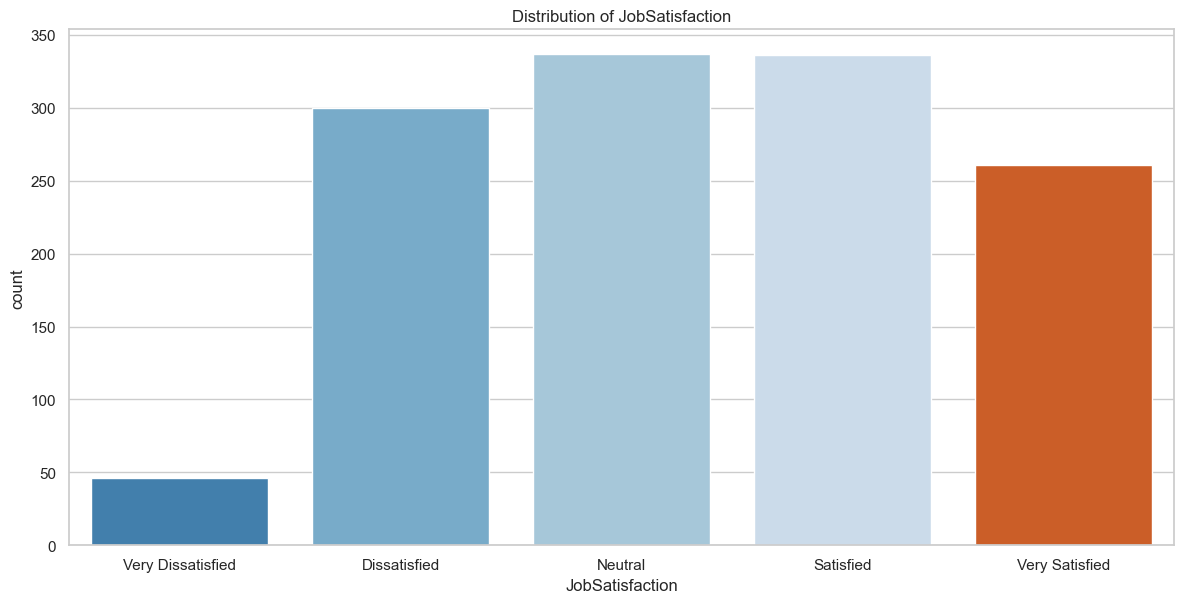

In [36]:
ql_stats(df2, 'JobSatisfaction')

- Shows a **varied** sentiment towards Job Satisfaction
- Most common responses are **Neutral (26.33%)** and **Satisfied (26.25%)**, followed by **Dissatisfied (23.44%)** and **Very Satisfied (20.39%)**. - Only **3.59%** of employees reported being **Very Dissatisfied**. 
- This relatively **balanced spread** suggests that job satisfaction by itself may not be a strong predictor of attrition,


--- Categorical Summary: SelfRating ---
                     Count  Percentages
SelfRating                             
Meets Expectations     448        35.00
Exceeds Expectation    444        34.69
Above and Beyond       388        30.31
Unacceptable             0         0.00
Needs Improvement        0         0.00
Unique categories: 3
Most frequent: Meets Expectations


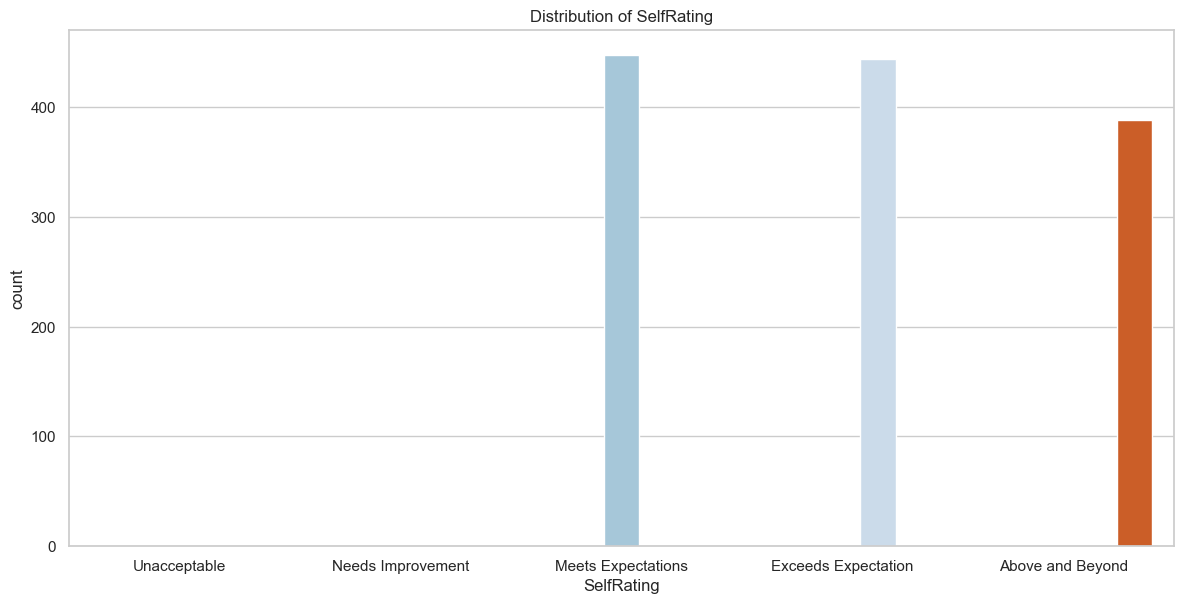

In [37]:
df2 = df_with_reviews
ql_stats(df2, 'SelfRating')

- Employees seem to rate themselves the most on a range between Meets Expectations and Above and Beyond, showing a relatively positive outlook on their work performance. 0 employees rated themselves Unacceptable or Needs Improvement. The difference between the employees who rated themselves Above and Beyond and Exceeds Expectations is only 4.38%, which indicates that the proportion of employees in Self Rating is relatively balanced. 

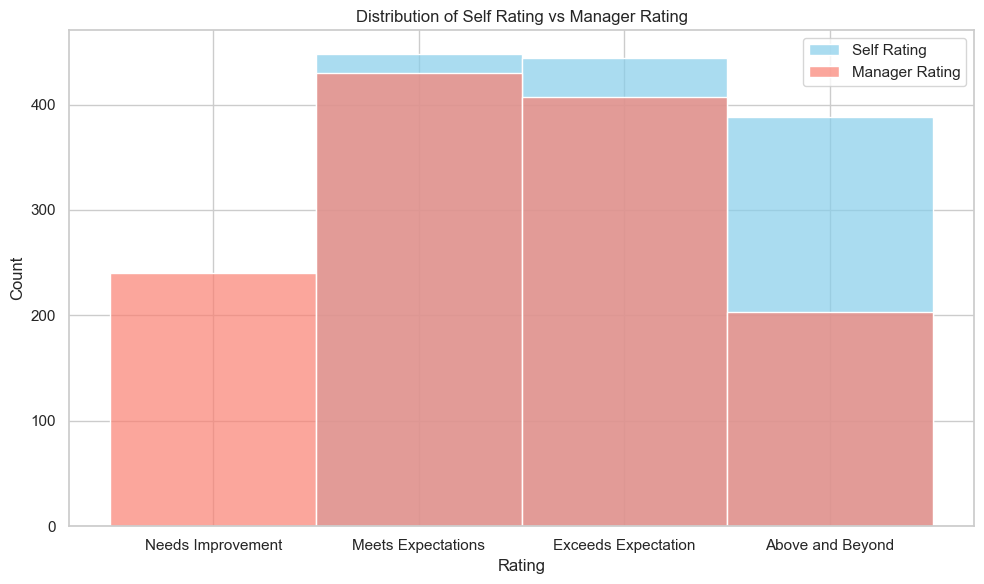


--- Categorical Summary: Manager Rating ---
                     Count  Percentages
ManagerRating                          
Meets Expectations     430        33.59
Exceeds Expectation    407        31.80
Needs Improvement      240        18.75
Above and Beyond       203        15.86
Unacceptable             0         0.00
Unique categories: 4
Most frequent: Meets Expectations


In [38]:
# plot distribution of SelfRating and ManagerRating for comparison
plt.figure(figsize=(10, 6))
sns.histplot(df2['SelfRating'], label='Self Rating', color='skyblue', stat='count', alpha=0.7, discrete=True)
sns.histplot(df2['ManagerRating'], label='Manager Rating', color='salmon', stat='count', alpha=0.7, discrete=True)
plt.title('Distribution of Self Rating vs Manager Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

counts = df2['ManagerRating'].value_counts(dropna=False)
percentages = df2['ManagerRating'].value_counts(normalize=True, dropna=False) * 100
print("\n--- Categorical Summary: Manager Rating ---")
summary = pd.DataFrame({
    'Count': counts,
    'Percentages': percentages.round(2)
})
print(summary)
print(f"Unique categories: {df2['ManagerRating'].nunique(dropna=False)}")
print(f"Most frequent: {df2['ManagerRating'].mode()[0]}")



In contrast with the Manager Rating, Managers seem to rate their employees more strict, with a lower percentage for a rating of Above and Beyond and a new 18.75% of employees who they rated Needs Improvement. No employees were rated an Unexceptable by their managers or themselves.

## Overall Findings
- The majority of employees are young, between 23 and **34** years old. 
- The salary range for all employees seem to center around $43,580 - $142,056, the low end of the spectrum.
- The company is most likely tech based, as 65.37% of employees work in the Technology Department.
- Recently (as of 2022), the company had an increase of 155 new employees, surpassing just slightly, the amount of employees they hired back in 2012.
- Most employees are in relatively new roles, with half of the company only being in their role for under a year. 
- Relating back to new roles, 0-2 years have passed since their last promotion for the majority of employees. 
- There was a drastic influx of reviews by the end of 2022, 1125 reviews were conducted, compared to 54 reviews in 2021.
- Job Satsifaction is relatively balanced across all employees, the rating that employees reported the most was Neutral (26.33%), the next highest rating being Satisfied (26.25%).
- Employees seem to highly regard their work performance, with all ratings falling between Meets Expectations and Above and Beyond.
- Managers are more strict towards work performance, stating that 18.75% of employees Need Improvement and only 15.86% of employees meeting Above and Beyond.

*Note: columns that were overall balanced or had fairly even proportions were not discussed here*

## 1. EDA - Bivariate Variables
Visualize and print out statistics for variables against Attrition

- Boxplots, pairplots, correlation heatmaps, Spearman's heatmap, stacked barplots, and line plots to help visualize correlation.


Statistics for Age by Attrition:
            count       mean       std   min   25%   50%   75%   max
Attrition                                                           
0          1233.0  29.460665  8.236182  18.0  23.0  27.0  35.0  51.0
1           237.0  26.540084  6.031299  18.0  22.0  26.0  29.0  48.0


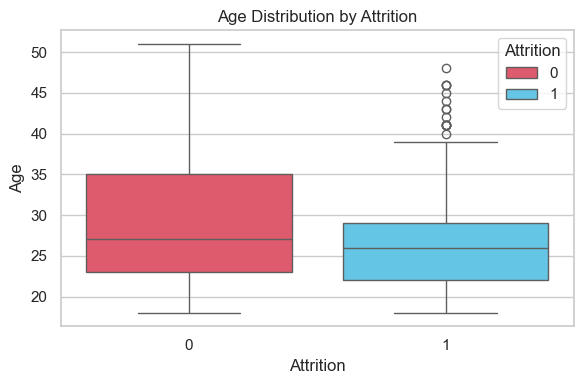

In [39]:
print("\nStatistics for Age by Attrition:")
print(df.groupby('Attrition')['Age'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['Age'], hue=df['Attrition'], palette=["#F4445E", "#50D0FA"])
plt.title('Age Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()

With Attrition=0 for employees who stayed and Attrition=1 for those who left, the boxplots show that the interquartile range (IQR) for employees who left is narrower, between 22–29 years. The mean and median are similar for both groups, differing by only 1–3 years. Both distributions are right-skewed, but employees who left have more outliers. The maximum age for employees who stayed is 51, while for those who left it is around 39, suggesting that younger employees are more likely to leave.

In [40]:
group0 = df.loc[df['Attrition'] == 0, 'Age'].dropna()
group1 = df.loc[df['Attrition'] == 1, 'Age'].dropna()

results = []

stat, p = stats.mannwhitneyu(group0, group1, alternative='two-sided')
results.append({
'Variable': 'Age',
'Test': 'Mann-Whitney U',
'Statistic/Corr': stat,
'p-value': p,
'Significant': p < 0.05
})

for row in results:
        interpret_results(row['Variable'], row['Test'], row['Statistic/Corr'], row['p-value'])

--- Age ---
Test: Mann-Whitney U
Statistic/Corr: 1.713e+05
p_value: 2.507e-05
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Age and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Age and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Age and Attrition.



After running the Mann-Whitney U Test, we see that there is a significant difference between Age and Attrition, which shows correlation.


Statistics for Salary by Attrition:
            count           mean            std      min      25%      50%  \
Attrition                                                                    
0          1233.0  118856.433090  105903.150384  20418.0  46388.0  75816.0   
1           237.0   82261.898734   82464.103025  20387.0  33273.0  50660.0   

                75%       max  
Attrition                      
0          152278.0  547204.0  
1           89771.0  539998.0  


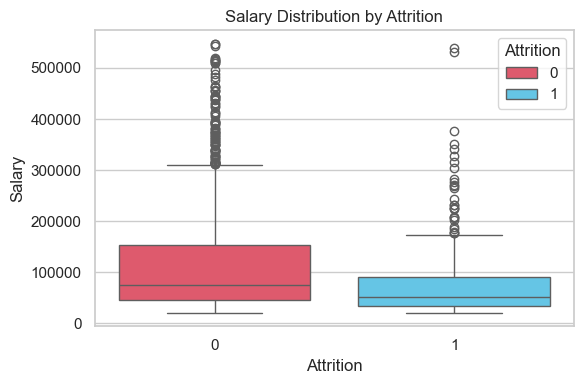

In [41]:
print("\nStatistics for Salary by Attrition:")
print(df.groupby('Attrition')['Salary'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['Salary'], hue=df['Attrition'], palette=["#F4445E", "#50D0FA"])
plt.title('Salary Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()

Similarly, the two boxplots for Salary against Attrition are both right-tailed, with the boxplot representing the employees left having a narrower IQR. Both of the boxplots also have numerous outliers. However, it does appear the salary for the employees who left does skew on the lower end. There is a possibility that a lower salary could drive employees to leave the company. 

In [42]:
group0 = df.loc[df['Attrition'] == 0, 'Salary'].dropna()
group1 = df.loc[df['Attrition'] == 1, 'Salary'].dropna()

results = []

stat, p = stats.mannwhitneyu(group0, group1, alternative='two-sided')
results.append({
'Variable': 'Salary',
'Test': 'Mann-Whitney U',
'Statistic/Corr': stat,
'p-value': p,
'Significant': p < 0.05
})

for row in results:
        interpret_results(row['Variable'], row['Test'], row['Statistic/Corr'], row['p-value'])



--- Salary ---
Test: Mann-Whitney U
Statistic/Corr: 1.861e+05
p_value: 2.436e-11
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Salary and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Salary and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Salary and Attrition.



After running the Mann-Whitney U Test, we see that Salary and Attrition do indeed have a significant difference with each other.


Statistics for Years At Company by Attrition:
            count      mean       std  min  25%  50%  75%   max
Attrition                                                      
0          1233.0  4.973236  3.266332  0.0  2.0  5.0  8.0  10.0
1           237.0  2.426160  2.476977  0.0  0.0  1.0  4.0  10.0


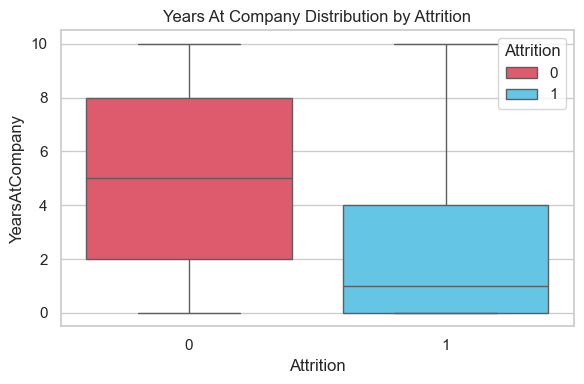

In [43]:
print("\nStatistics for Years At Company by Attrition:")
print(df.groupby('Attrition')['YearsAtCompany'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['YearsAtCompany'], hue=df['Attrition'], palette=["#F4445E", "#50D0FA"])
plt.title('Years At Company Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()

While tenure for the employees that stayed, looks relatively centered, the other boxplot looks right-skewed. More specifically, 75% of the employees that left only spent less than 4 years at the company. It indicates that there's a higher turnover rate for employees who are near the 3rd or 4th year of tenure. 

In [44]:
group0 = df.loc[df['Attrition'] == 0, 'YearsAtCompany'].dropna()
group1 = df.loc[df['Attrition'] == 1, 'YearsAtCompany'].dropna()

results = []

stat, p = stats.mannwhitneyu(group0, group1, alternative='two-sided')
results.append({
'Variable': 'Years At Company',
'Test': 'Mann-Whitney U',
'Statistic/Corr': stat,
'p-value': p,
'Significant': p < 0.05
})

for row in results:
        interpret_results(row['Variable'], row['Test'], row['Statistic/Corr'], row['p-value'])

--- Years At Company ---
Test: Mann-Whitney U
Statistic/Corr: 2.118e+05
p_value: 2.883e-28
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Years At Company and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Years At Company and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Years At Company and Attrition.



The Mann-Whitney U Test confirms that there is a difference between Years At Company and Attrition. 


Statistics for Years In Most Recent Role by Attrition:
            count      mean       std  min  25%  50%  75%   max
Attrition                                                      
0          1233.0  2.543390  2.600563  0.0  0.0  2.0  4.0  10.0
1           237.0  0.991561  1.672285  0.0  0.0  0.0  1.0   8.0


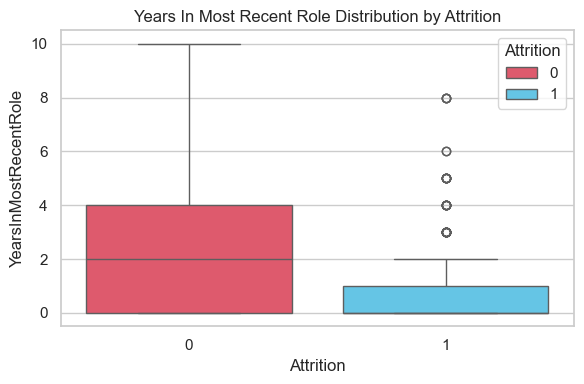

In [45]:
print("\nStatistics for Years In Most Recent Role by Attrition:")
print(df.groupby('Attrition')['YearsInMostRecentRole'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['YearsInMostRecentRole'], hue=df['Attrition'], palette=["#F4445E", "#50D0FA"])
plt.title('Years In Most Recent Role Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()

The boxplots for the Years In Most Recent Role is interesting because it shows that 75% of the employees that left, only spent less than under a year in their last role before leaving. The employees who have spent more than a year in their last role before leaving, are outliers and are considered extreme cases. 

In [46]:
group0 = df.loc[df['Attrition'] == 0, 'YearsInMostRecentRole'].dropna()
group1 = df.loc[df['Attrition'] == 1, 'YearsInMostRecentRole'].dropna()

results = []

stat, p = stats.mannwhitneyu(group0, group1, alternative='two-sided')
results.append({
'Variable': 'Years In Most Recent Role',
'Test': 'Mann-Whitney U',
'Statistic/Corr': stat,
'p-value': p,
'Significant': p < 0.05
})

for row in results:
        interpret_results(row['Variable'], row['Test'], row['Statistic/Corr'], row['p-value'])

--- Years In Most Recent Role ---
Test: Mann-Whitney U
Statistic/Corr: 2.026e+05
p_value: 4.134e-22
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Years In Most Recent Role and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Years In Most Recent Role and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Years In Most Recent Role and Attrition.



The Mann-Whitney U Test confirms that there is a difference between Years In Most Recent Role and Attrition.


Statistics for Years Since Last Promotion by Attrition:
            count      mean       std  min  25%  50%  75%   max
Attrition                                                      
0          1233.0  3.824818  2.935751  0.0  1.0  3.0  6.0  10.0
1           237.0  1.443038  2.054842  0.0  0.0  1.0  2.0   9.0


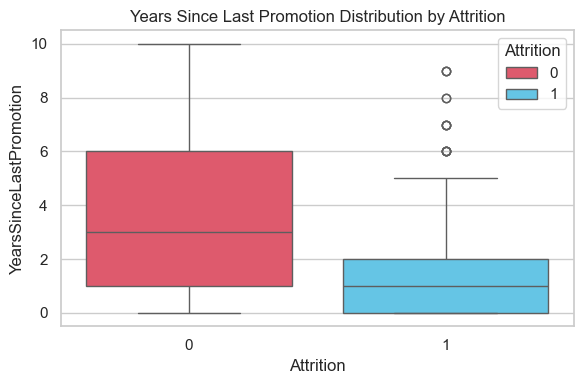

In [47]:
print("\nStatistics for Years Since Last Promotion by Attrition:")
print(df.groupby('Attrition')['YearsSinceLastPromotion'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['YearsSinceLastPromotion'], hue=df['Attrition'], palette=["#F4445E", "#50D0FA"])
plt.title('Years Since Last Promotion Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()

The boxplot representing the employees who left is smaller, with a shorter tail and some outliers. The boxplot representing the employees who stayed is also right-skewed, but has a wider IQR and no outliers. Furthermore, 75% of the employees who left only spent less than 2 years in their last role. Compared to the employees who still work for the company, 75% have spent less than 6 years in their most recent role. 

In [48]:
group0 = df.loc[df['Attrition'] == 0, 'YearsSinceLastPromotion'].dropna()
group1 = df.loc[df['Attrition'] == 1, 'YearsSinceLastPromotion'].dropna()

results = []

stat, p = stats.mannwhitneyu(group0, group1, alternative='two-sided')
results.append({
'Variable': 'Years In Last Promotion',
'Test': 'Mann-Whitney U',
'Statistic/Corr': stat,
'p-value': p,
'Significant': p < 0.05
})

for row in results:
        interpret_results(row['Variable'], row['Test'], row['Statistic/Corr'], row['p-value'])

--- Years In Last Promotion ---
Test: Mann-Whitney U
Statistic/Corr: 2.195e+05
p_value: 4.048e-35
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Years In Last Promotion and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Years In Last Promotion and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Years In Last Promotion and Attrition.



The Mann-Whitney U Test confirms that Years Since Last Promotion is correlated with Attrition.


Statistics for Years With Current Manager by Attrition:
            count      mean       std  min  25%  50%  75%   max
Attrition                                                      
0          1233.0  2.480941  2.583005  0.0  0.0  2.0  4.0  10.0
1           237.0  0.983122  1.537570  0.0  0.0  0.0  1.0   7.0


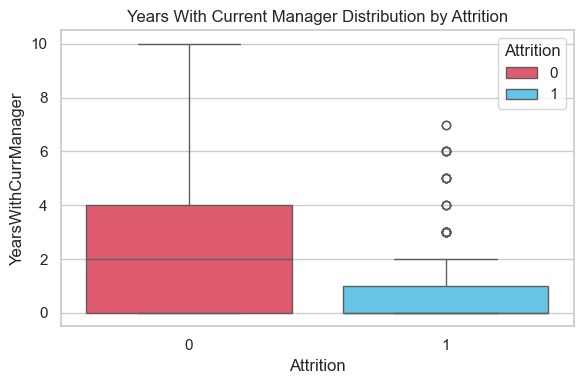

In [49]:
print("\nStatistics for Years With Current Manager by Attrition:")
print(df.groupby('Attrition')['YearsWithCurrManager'].describe())
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Attrition'], y=df['YearsWithCurrManager'], hue=df['Attrition'], palette=["#F4445E", "#50D0FA"])
plt.title('Years With Current Manager Distribution by Attrition')
plt.tight_layout()
plt.show()
plt.close()

The shape for both of the boxplots looks very similar to the Years Since Last Promotion vs Attrition boxplots. This usually happens when there's low variability in the data. Furthermore, the IQR for Attrition=1 is even narrower, with 75% only spending less than under a year with their last manager. For the employees who stayed, 75% of them have spent less than 4 years with their current manager so far. 

In [50]:
group0 = df.loc[df['Attrition'] == 0, 'YearsWithCurrManager'].dropna()
group1 = df.loc[df['Attrition'] == 1, 'YearsWithCurrManager'].dropna()

results = []

stat, p = stats.mannwhitneyu(group0, group1, alternative='two-sided')
results.append({
'Variable': 'Years With Current Manager',
'Test': 'Mann-Whitney U',
'Statistic/Corr': stat,
'p-value': p,
'Significant': p < 0.05
})

for row in results:
        interpret_results(row['Variable'], row['Test'], row['Statistic/Corr'], row['p-value'])

--- Years With Current Manager ---
Test: Mann-Whitney U
Statistic/Corr: 2.004e+05
p_value: 1.629e-20
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Years With Current Manager and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Years With Current Manager and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Years With Current Manager and Attrition.



The Mann-Whitney U Test confirms that there is an association between Years With Current Manager and Attrition.


Statistics for Business Travel by Attrition:
Attrition             0    1
BusinessTravel              
Frequent Traveller  208   69
No Travel           138   12
Some Travel         887  156


/var/folders/m4/yjvjdcbn13v_8w2jnkcpn2jr0000gn/T/ipykernel_47377/3178077167.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('BusinessTravel')['Attrition'].value_counts().unstack().fillna(0))


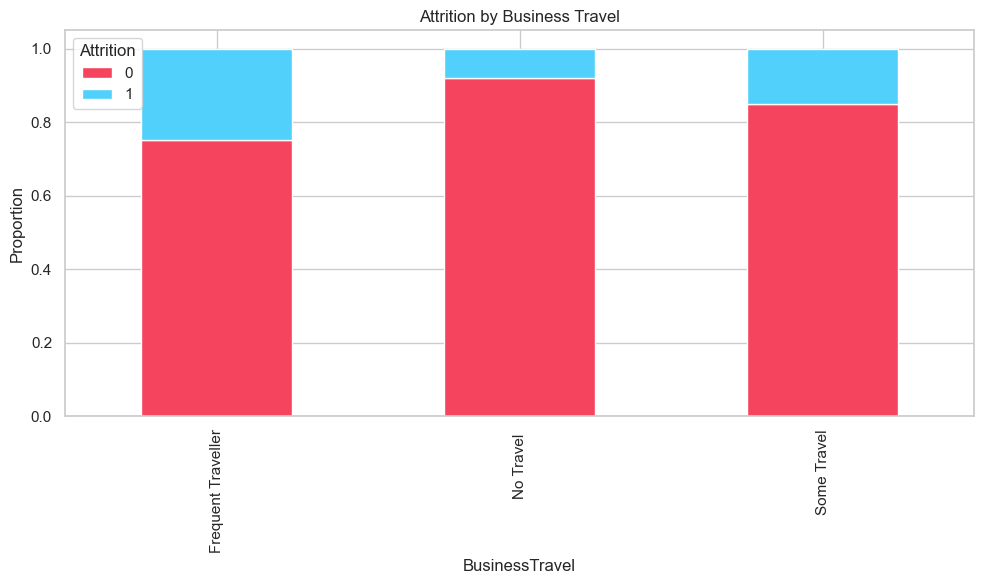

In [51]:
print("\nStatistics for Business Travel by Attrition:")
print(df.groupby('BusinessTravel')['Attrition'].value_counts().unstack().fillna(0))
cross_tab = pd.crosstab(df['BusinessTravel'], df['Attrition'])
cross_tab_pct = cross_tab.div(cross_tab.sum(1), axis=0)
cross_tab_pct.plot(kind='bar', stacked=True, figsize=(10, 6), color=["#F4445E", "#50D0FA"])
plt.ylabel('Proportion')
plt.title('Attrition by Business Travel')
plt.legend(title='Attrition')
plt.tight_layout()
plt.show()
plt.close()

The proportion of employees who stayed/left is relatively similar across all categories, but for the employees who have frequently traveled for business have the highest rate of attrition (4.69%). There's also an overall high rate of retention across all categories.

In [52]:
contingency_table = pd.crosstab(df['BusinessTravel'], df['Attrition'])
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

results = []

chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
results.append({'Variable': 'Business Travel', 
                'Test': 'Chi-square', 
                'Statistic/Corr': chi2, 
                'p-value': p,
                'Significant': p < 0.05
                })

for row in results:
        interpret_results(row['Variable'], row['Test'], row['Statistic/Corr'], row['p-value'])

--- Business Travel ---
Test: Chi-square
Statistic/Corr: 24.18
p_value: 5.609e-06
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Business Travel and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Business Travel and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Business Travel and Attrition.



The Chi-Square Test confirms that there is a relationship between Business Travel and Attrition.


Statistics for Job Role by Attrition:
Attrition                    0   1
JobRole                           
Analytics Manager           49   3
Data Scientist             199  62
Engineering Manager         73   2
HR Business Partner          7   0
HR Executive                25   3
HR Manager                   4   0
Machine Learning Engineer  136  10
Manager                     35   2
Recruiter                   15   9
Sales Executive            270  57
Sales Representative        50  33
Senior Software Engineer   123   9
Software Engineer          247  47


/var/folders/m4/yjvjdcbn13v_8w2jnkcpn2jr0000gn/T/ipykernel_47377/2858835270.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('JobRole')['Attrition'].value_counts().unstack().fillna(0))


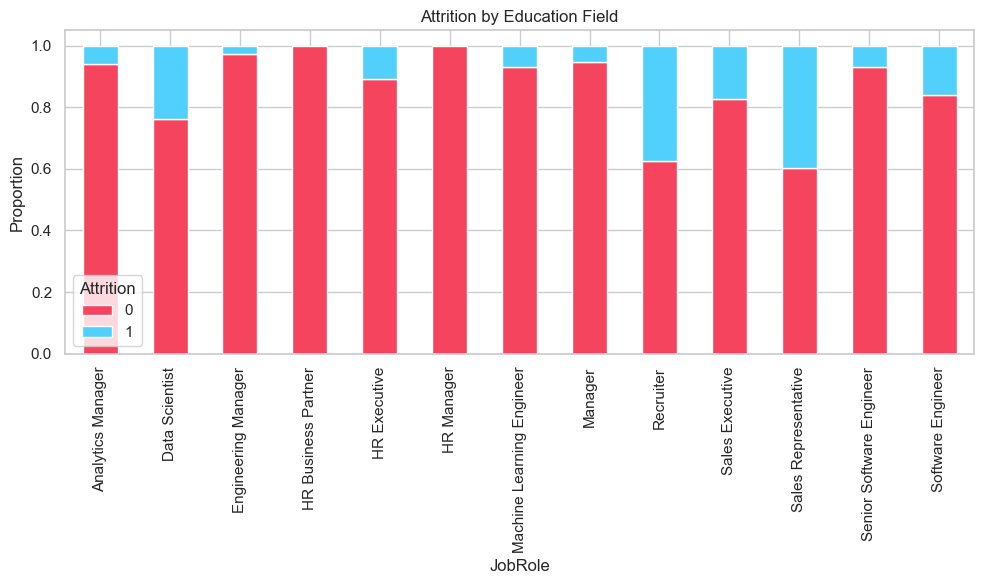

In [53]:
print("\nStatistics for Job Role by Attrition:")
print(df.groupby('JobRole')['Attrition'].value_counts().unstack().fillna(0))
cross_tab = pd.crosstab(df['JobRole'], df['Attrition'])
cross_tab_pct = cross_tab.div(cross_tab.sum(1), axis=0)
cross_tab_pct.plot(kind='bar', stacked=True, figsize=(10, 6), color=["#F4445E", "#50D0FA"])
plt.ylabel('Proportion')
plt.title('Attrition by Education Field')
plt.legend(title='Attrition')
plt.tight_layout()
plt.show()
plt.close()

For Job Role, you can see relatively high retention rates for various types of roles. However, the Job Role with the most Attrition is Sales Representative with 33 out of 83 employees with Attrition. In contrast, the highest retention rate are HR Business Partner employees, with 0 employees leaving the company. Specifically, the roles with little to no attrition come from mostly senior roles such as Analytics Manager, Engineering Manager, HR Manager, etc. The two roles with the highest attrition are previously mentioned Sales Representatives, and Recruiters. These roles are mostly entry-level or non-tech based.

In [54]:
contingency_table = pd.crosstab(df['JobRole'], df['Attrition'])
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

results = []

chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
results.append({'Variable': 'Job Role', 
                'Test': 'Chi-square', 
                'Statistic/Corr': chi2, 
                'p-value': p,
                'Significant': p < 0.05
                })

for row in results:
        interpret_results(row['Variable'], row['Test'], row['Statistic/Corr'], row['p-value'])

--- Job Role ---
Test: Chi-square
Statistic/Corr: 91.82
p_value: 2.19e-14
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Job Role and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Job Role and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Job Role and Attrition.



With the Chi-Square test confirming association between Job Role and Attrition, it implies that employees who do not hold senior positions, tend to leave the company more than other employees.


Statistics for Overtime by Attrition:
              mean  count       std
OverTime                           
0         0.104364   1054  0.305878
1         0.305288    416  0.461084


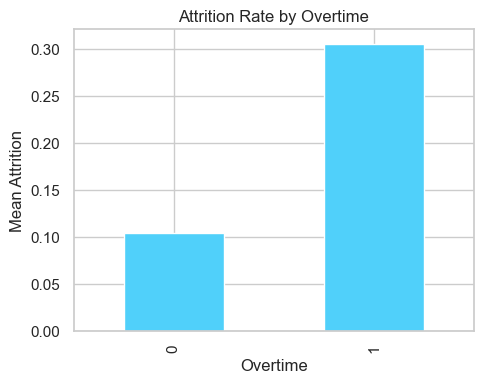

In [55]:
print(f"\nStatistics for Overtime by Attrition:")
print(df.groupby('OverTime')['Attrition'].agg(['mean', 'count', 'std']))

ct = df.groupby('OverTime')['Attrition'].mean()

plt.figure(figsize=(5,4))
ct.plot(kind='bar', color="#50D0FA")
plt.ylabel('Mean Attrition')
plt.xlabel('Overtime')
plt.title('Attrition Rate by Overtime')
plt.tight_layout()
plt.show()
plt.close()

As Overtime=1 represents employees who do work overtime, it seems like they are more likely to leave the company than those who don't work overtime. The mean attrition is 0.1 for employees who don't work overtime, while the mean attrition is 0.3 for employees who do. 

In [56]:
contingency_table = pd.crosstab(df['OverTime'], df['Attrition'])
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

results = []

chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
results.append({'Variable': 'Overtime', 
                'Test': 'Chi-square', 
                'Statistic/Corr': chi2, 
                'p-value': p,
                'Significant': p < 0.05
                })

for row in results:
        interpret_results(row['Variable'], row['Test'], row['Statistic/Corr'], row['p-value'])

--- Overtime ---
Test: Chi-square
Statistic/Corr: 87.56
p_value: 8.158e-21
Significance level: 0.05 (95.0% confidence)
Null hypothesis (H0): There is no relationship/difference between Overtime and Attrition.
Alternative hypothesis (Ha): There is a relationship/difference between Overtime and Attrition.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant relationship/difference between Overtime and Attrition.



With the Chi-Square Test, it confirms that Overtime does affect Attrition and implies that it drives employees to leave the company.

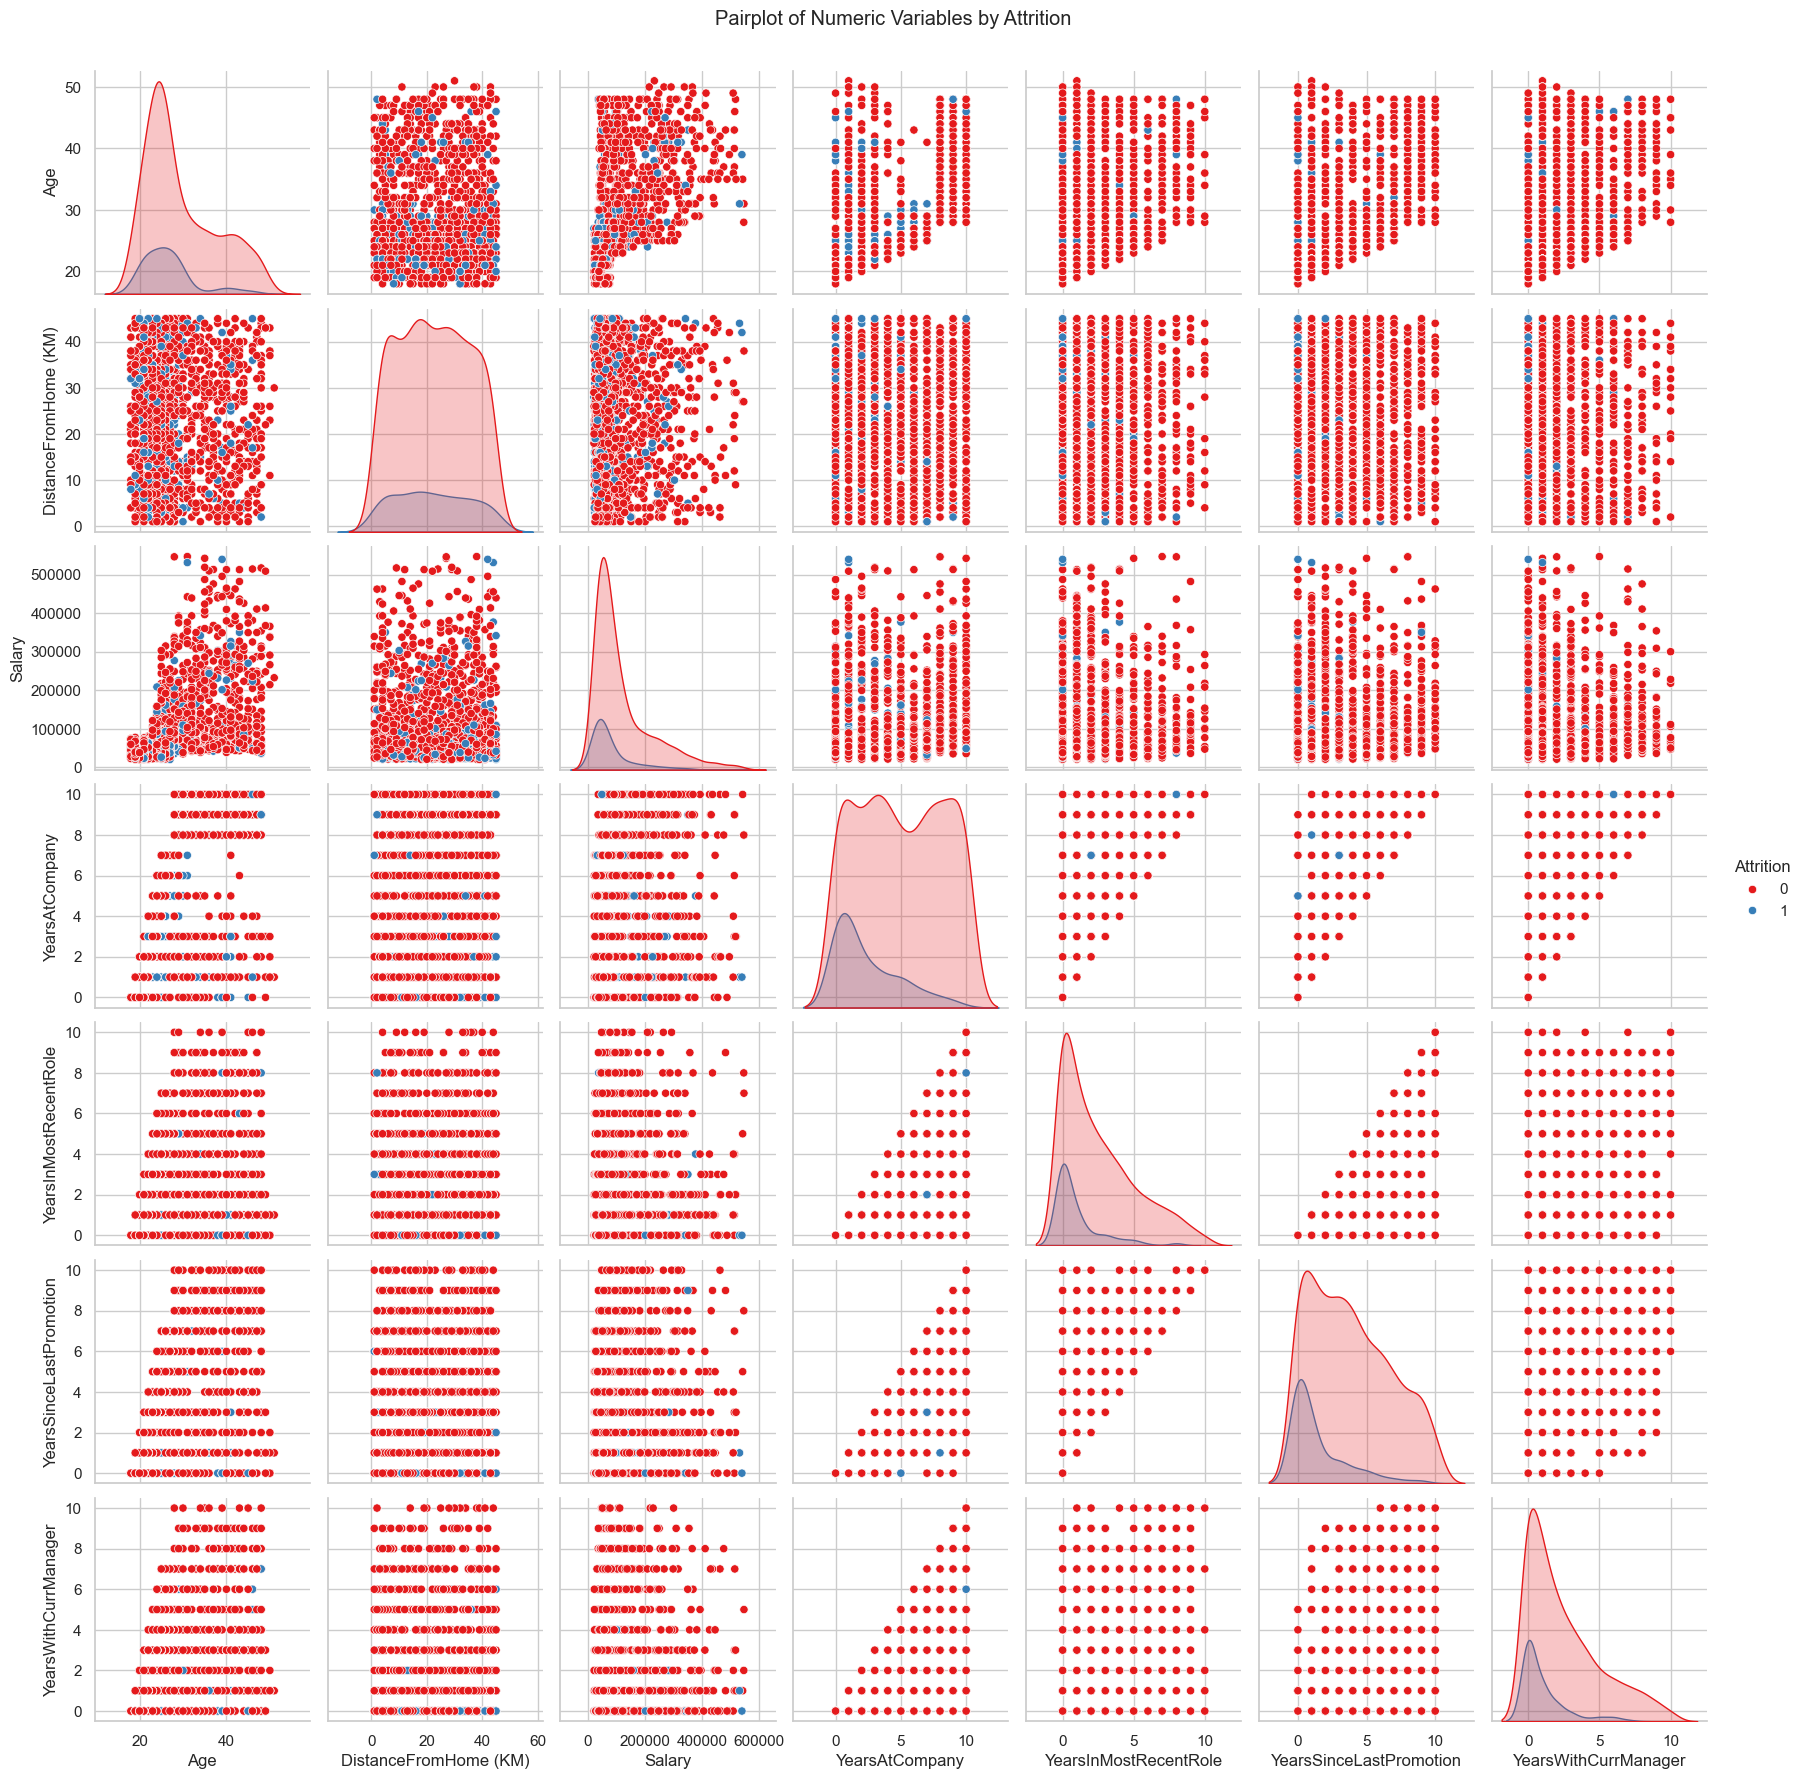

In [57]:
df['OverTime'] = df['OverTime'].astype('category')

sns.pairplot(df, hue="Attrition", diag_kind='kde', palette='Set1')
plt.suptitle('Pairplot of Numeric Variables by Attrition', y=1.02)
plt.show()
plt.close()

### Pairplot (Scatterplot Matrix)
Correlations: 
- Age vs Salary (Positive)
- Age vs Years At Company (Positive)
- Age vs Years In Most Recent Role (Positive)
- Age vs Years Since Last Promotion (Positive)
- Age vs Years with Current Manager (Positive)
- Distance From Home vs Salary (Positive)
- Salary vs Years With Current Manager (Negative)
- Years At Company vs Years In Most Recent Role (Positive)
- Years At Company vs Years Since Last Promotion (Positive)
- Years At Company vs Years With Current Manager (Positive)
- Years In Most Recent Role vs Years Since Last Promotion (Positive)
- Years Since Last Promotion vs Years With Current Manager (Weak Positive)


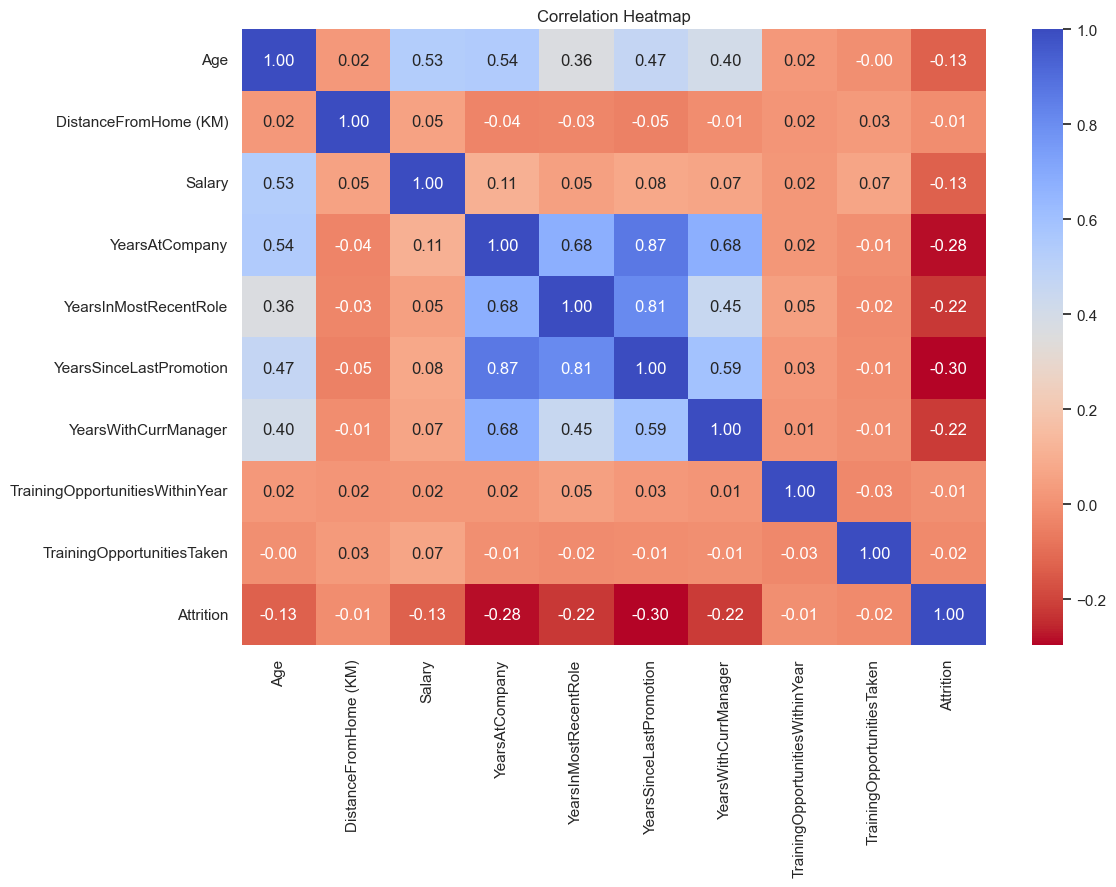

In [58]:
numeric_cols = []
for col in df_all.columns:
    if pd.api.types.is_numeric_dtype(df_all[col]):
            if df_all[col].nunique(dropna=True) > 2:
                numeric_cols.append(col)

plt.figure(figsize=(12,8))
corr = df_all[numeric_cols + ['Attrition']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm_r', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()
plt.close()

### Correlation Heatmap
The closer a coefficient value is to -1 or to 1, the higher correlation it has. Coefficents near 0 means no correlation.

For Attrition, the features that have the most correlation is Years At Company (-0.28), Years Since Last Promotion (-0.3), Years In Most Recent Role (-0.22), and Years WIth Current Manager (-0.22). As these features increase, attrition decreases as well. This is also what we saw in the previous plots, the less time spent overall in the company, most recent role, between promotions, and with their manager, the more likely an employee was going to leave. 

Years At Company and Years Since Last Promotion have the highest positive coefficient, which higher tenure has an association with how the timespan between promotions.

Although Age isn't one of the highest coefficients for Attrition, it still affects Salary, Years At Company, and Years Since Last Promotion. This implies that older employees are associated with higher salaries, longer tenure, and longer time between promotions.


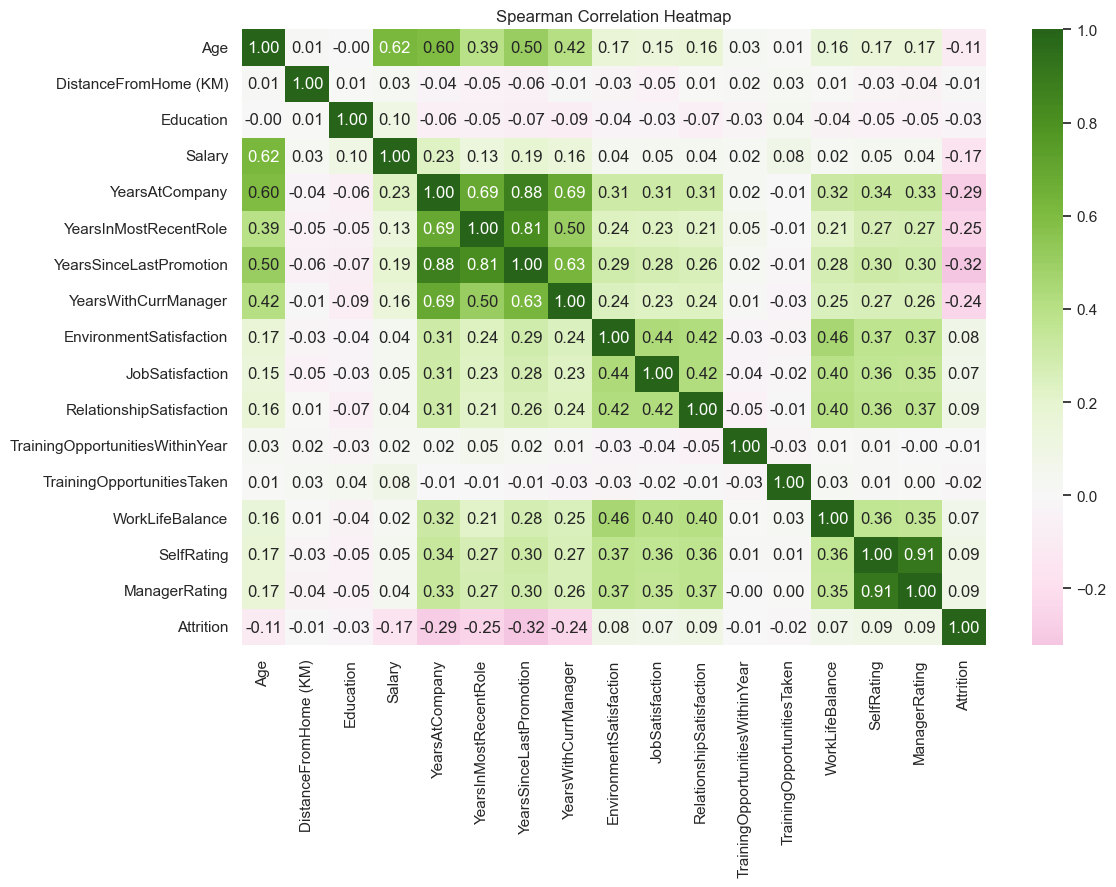

In [59]:
ordinal_cols = {}
spearman_cols = []
for col in df_all.columns:
    if col == 'Attrition':
        continue  
    elif isinstance(df_all[col].dtype, CategoricalDtype):
        if df_all[col].dtype.ordered:
            ordinal_cols[col] = list(df_all[col].cat.categories)
            df_all[col] = df_all[col].cat.codes
            spearman_cols.append(col)
    
    elif pd.api.types.is_numeric_dtype(df_all[col]):
        if df_all[col].nunique(dropna=True) != 2:
            spearman_cols.append(col)

bivar_spearman_plot(df_all, spearman_cols)

### Spearman's Heatmap
Correlation heatmap with ordinal variables.

- Just like the correlation heat map, Years Since Last Promotion and Years At Company have the most correlation with Attrition.

- The ordinal features coefficients are all very close to zero, which means it has very little effect on Attrition.

# Top 10 Most Significant Features

In [60]:
results_df = nparametric_tests(df)
results_df.head(10)

,Variable,Test,Statistic/Corr,p-value,Significant
0,YearsSinceLastPromotion,Mann-Whitney U,219506.500000,4.047606e-35,True
1,YearsAtCompany,Mann-Whitney U,211792.500000,2.882669e-28,True
2,YearsInMostRecentRole,Mann-Whitney U,202572.500000,4.133512e-22,True
3,OverTime,Chi-square,87.564294,8.158424e-21,True
4,YearsWithCurrManager,Mann-Whitney U,200382.500000,1.628979e-20,True
5,JobRole,Chi-square,91.821647,2.189897e-14,True
6,StockOptionLevel,Chi-square,60.598301,4.379390e-13,True
7,Salary,Mann-Whitney U,186074.500000,2.436089e-11,True
8,MaritalStatus,Chi-square,34.496881,3.229218e-08,True
9,BusinessTravel,Chi-square,24.182414,5.608614e-06,True


# 3. Predictive Modeling
- Full models
    - Random Forest + SMOTE
    - Logistic Regression + SMOTE
- Limited Models (Using the top 10 significant features)
    - Random Forest Limited + SMOTE
    - Random Forest Limited + SMOTE
- Ensemble Model (Full Model + SMOTE)


Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   EmployeeID               1470 non-null   object        
 1   Gender                   1470 non-null   category      
 2   Age                      1470 non-null   int64         
 3   BusinessTravel           1470 non-null   category      
 4   Department               1470 non-null   category      
 5   DistanceFromHome (KM)    1470 non-null   int64         
 6   State                    1470 non-null   category      
 7   Ethnicity                1470 non-null   category      
 8   Education                1470 non-null   category      
 9   EducationField           1470 non-null   category      
 10  JobRole                  1470 non-null   category      
 11  MaritalStatus            1470 non-null   category      
 12  Salary                  

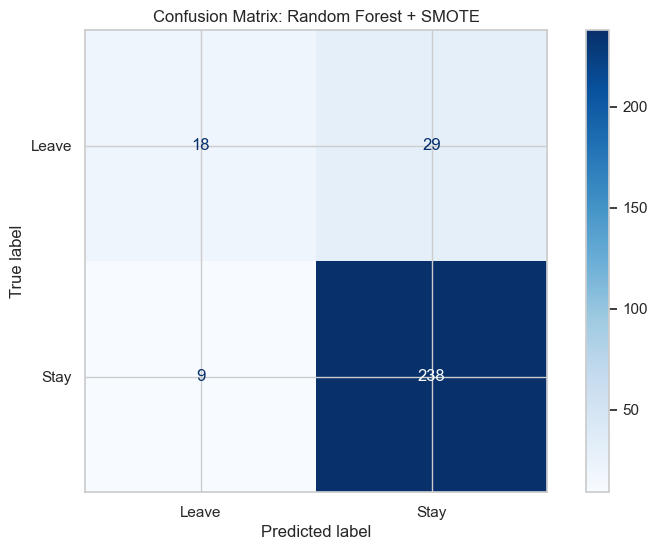

--- Logistic Regression + SMOTE ---
Accuracy: 0.7312925170068028
Precision: 0.32608695652173914
Recall: 0.6382978723404256
ROC-AUC: 0.7878370229993971
              precision    recall  f1-score   support

           0       0.92      0.75      0.82       247
           1       0.33      0.64      0.43        47

    accuracy                           0.73       294
   macro avg       0.62      0.69      0.63       294
weighted avg       0.82      0.73      0.76       294



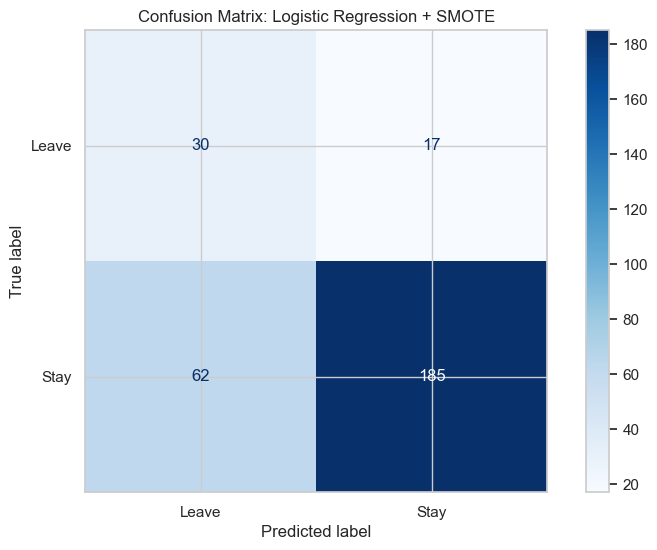

Cross-validating Random Forest (Limited)...
roc_auc (5-fold CV): mean=0.812, std=0.031
Cross-validating Logistic Regression (Limited)...
roc_auc (5-fold CV): mean=0.844, std=0.013
--- Random Forest (Limited) + SMOTE ---
Accuracy: 0.8061224489795918
Precision: 0.34375
Recall: 0.23404255319148937
ROC-AUC: 0.7458868119562408
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       247
           1       0.34      0.23      0.28        47

    accuracy                           0.81       294
   macro avg       0.60      0.57      0.58       294
weighted avg       0.78      0.81      0.79       294



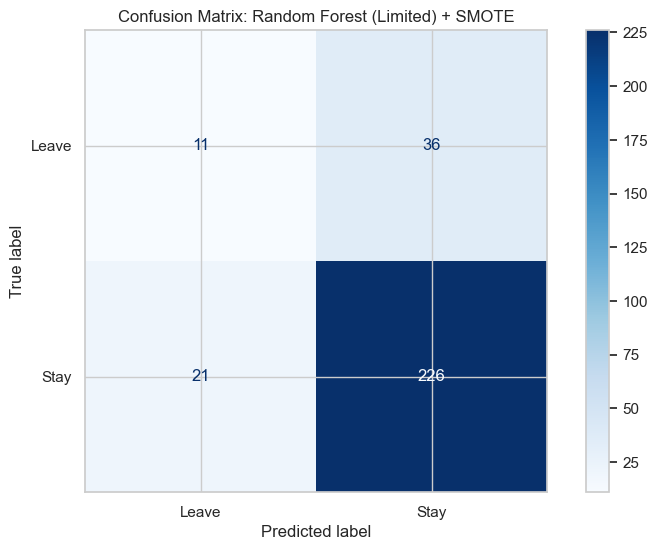

--- Logistic Regression (Limited) + SMOTE ---
Accuracy: 0.6938775510204082
Precision: 0.29523809523809524
Recall: 0.6595744680851063
ROC-AUC: 0.7759496942027737
              precision    recall  f1-score   support

           0       0.92      0.70      0.79       247
           1       0.30      0.66      0.41        47

    accuracy                           0.69       294
   macro avg       0.61      0.68      0.60       294
weighted avg       0.82      0.69      0.73       294



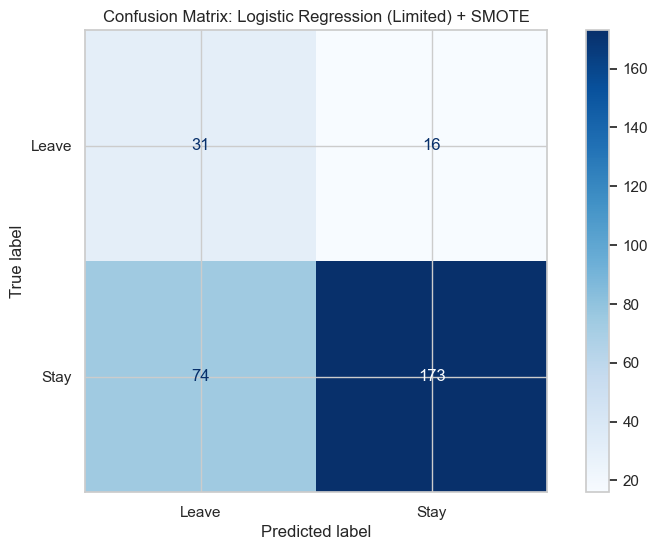

Cross-validating Ensemble (Full Models)...
Ensemble ROC-AUC (5-fold CV): mean=0.869, std=0.014
--- Ensemble (Full Models + SMOTE) ---
Accuracy: 0.8231292517006803
Precision: 0.45098039215686275
Recall: 0.48936170212765956
ROC-AUC: 0.8088551985528469
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       247
           1       0.45      0.49      0.47        47

    accuracy                           0.82       294
   macro avg       0.68      0.69      0.68       294
weighted avg       0.83      0.82      0.83       294



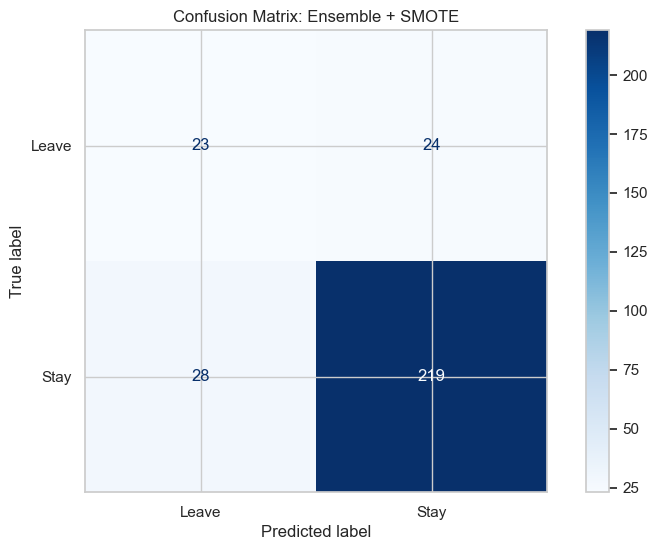

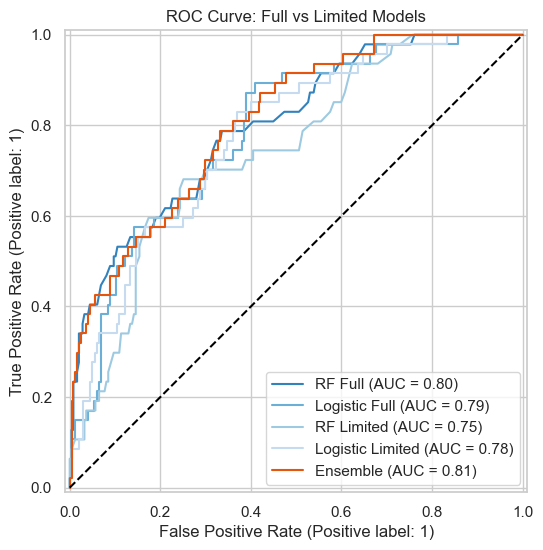

In [61]:
run_pipeline('hr_only')

## Overall Findings
### Cross Validation
- Random Forest: mean=0.862, std=0.024
- Logistic Regression: mean=0.851, std=0.014
- Random Forest (Limited): mean=0.812, std=0.031
- Logistic Regresion (Limited): mean=0.844, std=0.013
- Ensemble (Full Model): mean=0.869, std=0.014
<p><b>Overall, the model that performs the best is the Ensemble Model, while the model that is the most consistent across folds is the Logistic Regression (Limited) Model.</p></b>


### Random Forest (Full + SMOTE)
- High accuracy: 87% of the employees were correctly predicted as stayers or leavers.
- Moderately high precision: 67% of the employees that are predicted to leave, did leave the company.
- Low recall: 38% of the employees that did leave, were accurately predicted to leave by the model.
- Confusion Matrix
    - True Negative: 238 employees were accurately predicted to stay.
    - False Positive: 9 employees were inaccurately predicted to leave.
    - True Positive: 18 employees were accurately predicted to leave.
    - False Negative: 29 employees were inaccurately predicted to stay.

### Logistic Regression + SMOTE
- High accuracy: 73% of all employees are accurately predicted as stayers or leavers.
- Low Precision: 33% of the employees who were predicted to leave, did leave the company.
- Moderate Recall: 64% of the employees who did leave, were accurately predicted to leave by the model.
- Confusion Matrix:
    - True Negative: 185 employees were accurately predicted to stay.
    - False Positive: 62 employees were inaccurately predicted to leave.
    - True Positive: 80 employees were accurately predicted to leave.
    - False Negative: 17 employees were inaccurately predicted to stay.

### Random Forest (Limited) + SMOTE
- High accuracy: 80% of all employees are accurately identified as stayers/leavers.
- Low Precision: 34% of the employees that were predicted to leave, did leave the company.
- Low Recall: 23% of the employees that did leave, were accurately predicted to leave by the model.
- Confusion Matrix
    - True Negative: 226 employees were accurately predicted to stay.
    - False Positive: 21 employees were inaccurately predicted to leave.
    - True Positive: 11 employees were accurately predicted to leave.
    - False Negative: 36 employees were inaccurately predicted to stay.

### Logistic Regression (Limited) + SMOTE
- Moderate Accuracy: 69% of all employees are accurately identified as stayers/leavers.
- Low Precision: 30% of the employees that were predicted to leave, did leave the company.
- Moderate Recall: 66% of the employees that did leave, were correctly predicted to leave by the model.
- Confusion Matrix
    - True Negative: 173 employees were accurately predicted to stay.
    - False Positive: 74 employees were inaccurately predicted to leave.
    - True Positive: 31 employees were accurately predicted to leave.
    - False Negative: 16 employees were inaccurately predicted to stay.

### Ensemble + SMOTE
- High Accuracy: 82% of all employees are accurately predicted as stayers/leavers.
- Moderate Precision: 45% of the employees who were predicted to leave, did leave the company.
- Moderate Recall: 49% of all employees who did leave, were accurately predicted to leave by the model.
Confusion Matrix
    - True Negative: 219 employees were accurately predicted to stay.
    - False Positive: 23 employees were inaccurately predicted to leave.
    - True Positive: 23 employees were accurately predicted to leave.
    - False Negative: 24 employees were inaccurately predicted to stay.

# Conclusion
### Which Model to Use?
The top three models to look into are the Random Forest, Logistic Regression, and Ensemble Model. 
- Random Forest has a strong accuracy and good precision. It's able to pinpoint and accurately predict employees that are "high-risk" for attrition. However, it misses a portion of employees who are not "high-risk", which do end up leaving the company.
- The Logistic Regression model has lower precision, which means that while it might detect a larger amount of leavers, it also can falsely predict employees as "leavers" who end up staying. In a business context, resources or effort spent can be wasted on employees who do not end up leaving the company. 
- The Ensemble Model is the most balanced and the best performing model out of these three. Its strong accuracy and recall makes it the best predictor. The only drawback is that it has the most complex pipeline and can also be the most difficult to interpret. 

Hence, the best model will depend on what the company wants to prioritize on. If the comapny's goal is to have the best accuracy or balanced performance, the Ensemble is ultimately the strongest choice. If the company thinks simplicity is the most important attribute, Logistic Regression should be used. If the focus is on determining which employees are the most "high-risk", Random Forest will help the most.

An alternate solution that a company may try is to use another model to use side-by-side to offer more insights and better decision-making. For example, the Ensemble Model can be used alongside Logistic Regression to help make the results more interpretable for HR to understand. Furthermore, the Random Forest model can be more beneficial if the company is more interested in high-risk employees without inaccurately predicting the rest of the company's employees. 

Furthermore, EDA showed that only a small porportion of employees left the company in the original dataset, with most plots tending to be right-skewed. In turn, accuracy may not be a sufficient measure of model performance. It would be more beneficial to look at precision, recall, and ROC-AUC to determine the next best path. In addition, knowing that the employees that left were most affected by the time spent between promotions and tenure in both recent role and at the company, it'd be best to use the model with the highest precision: the Logistic Regression + SMOTE Full Model. The model will effectively identify key groups of employees that are high-risk without misdirecting HR efforts toward employees that are unlikely to leave.